In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch
import statsmodels.formula.api as smf
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.spatial import distance

import rpy2
print(rpy2.__version__)

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')
mn = importr('metansue')


from rpy2.robjects import numpy2ri
numpy2ri.activate()

grdevices = importr('grDevices')
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
%matplotlib inline

3.1.0


/Users/nielsond/miniconda3/envs/ge2/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
data_path = Path('../great_expectations_data/data')
output_path = Path('../great_expectations_data/cleaned_data')
output_path.mkdir(exist_ok=True)
figure_path = Path('../great_expectations_figures/')
figure_path.mkdir(exist_ok=True)

In [3]:
def re_meta(ns, rs):
    Ts = np.arctanh(rs)
    vs = 1 / (ns-3)
    ws = 1 / vs
    Q = np.sum(ws * (Ts**2)) - ((np.sum(ws*Ts)**2)/np.sum(ws))
    df = len(ns) - 1
    C = np.sum(ws) - np.sum(ws**2)/np.sum(ws)
    if Q > df:
        tau_squared = (Q - df) / C
    else:
        tau_squared = 0
        
    v_stars = vs + tau_squared
    w_stars = 1/v_stars
    T_sb = np.sum(w_stars*Ts)/np.sum(w_stars)
    se_T = np.sqrt(1 / np.sum(w_stars))
    return T_sb, se_T, tau_squared

def calc_delta_se(r, means, ses):
    means = np.array(means)
    ses = np.array(ses)
    t = np.arctanh(r)
    se = np.abs(t) * np.sqrt(((ses / means)**2).sum())
    return t,se

def get_rci(r,tse, alpha=0.05, two_sided=True):
    za = stats.norm.ppf(1 - (alpha / (1+two_sided)))
    tbs = np.arctanh(r)
    uci = np.tanh(tbs + (tse * za))
    lci = np.tanh(tbs - (tse * za))
    return lci,uci

alpha = 0.05
two_sided = True
beta = 0.8
effect = -0.18
# Sample size for simple correlation
# https://www2.ccrb.cuhk.edu.hk/stat/other/correlation.htm
# Reference: Lachin (1981) Controlled Clinical Trials 2: 93-113
def calc_ss(effect, alpha=0.05, two_sided=True, beta = 0.8):
    za = stats.norm.ppf(1 - (alpha / (1+two_sided)))
    zb = np.abs(stats.norm.ppf(1 - beta))
    zeff = np.arctanh(effect)
    return (((za + zb)/zeff)**2) + 3
# Test sample size function

assert np.round(calc_ss(0.4)) == 47

In [4]:
robjects.r('mnin <- NULL')
robjects.r('meta_res <- NULL')
robjects.r("""makeinput <- function(r, n, labels){
              mnin = zcor_from_r(r, n, alpha = 0.05, labels = labels)
              print(mnin)
              assign("mnin", mnin, envir = .GlobalEnv)
              mnin
              }""")
makeinput = robjects.globalenv["makeinput"]

robjects.r("""runmeta <- function(mnin){
meta_res = meta(mnin, n.imp=1000)
assign("meta_res", mnin, envir = .GlobalEnv)
print(meta_res)
meta_res
}""")
runmeta = robjects.globalenv["runmeta"]

robjects.r("""runloo <- function(mnin){
loo_res = leave1out(mnin, n.imp=1000)
loo_res
}""")
runloo = robjects.globalenv["runloo"]

robjects.r("""runmb <- function(meta_res){
mb_res = metabias(meta_res)
mb_res
}""")
runmb = robjects.globalenv["runmb"]

robjects.r("""printforest <- function(meta_res){
forest(meta_res)
}
""")
print_forest = robjects.globalenv["printforest"]


robjects.r("""printfunnel <- function(meta_res){
funnel(meta_res)
}
""")
print_funnel = robjects.globalenv["printfunnel"]

robjects.r("""printfunnel <- function(meta_res){
funnel(meta_res)
}
""")
print_funnel = robjects.globalenv["printfunnel"]
robjects.r("""
library("metansue")
loohack <-
function (x, formula = ~1, hypothesis = NULL, n.imp = 500, maxiter = 200, 
    tol = 1e-06, ...)
    {
    call <- match.call()
    y <- x$y
    n.stud <- length(y)
    model <- metansue:::.check.formula(call, formula, n.stud)
    hypothesis <- metansue:::.check.hypothesis(call, hypothesis, model)
    if (n.imp < 2) {
        .stop(call, "The number of imputations must be at least 2")
    }
    nsue_i <- x
    model_i <- model
    obj <- list()
    for (i in 1:n.stud) {
        nsue_i$y <- x$y[-i]
        nsue_i$y_lo <- x$y_lo[-i]
        nsue_i$y_up <- x$y_up[-i]
        n <- x$aux[-i, ]
        nsue_i$aux <-data.frame(n)
        nsue_i$labels <- x$labels[-i]
        class(nsue_i) <- "nsue"
        model_i$matrix <- as.matrix(model$matrix[-i, ])
        obj[[i]] <- list(study = x$labels[i], meta = metansue:::.meta.nsue(nsue_i, 
            model_i, hypothesis, n.imp, maxiter, tol))
    }
    class(obj) <- "leave1out.nsue"
    summary(obj)
    obj
}
""")
loohack = robjects.globalenv["loohack"]

def get_fit_info(mr):
    mr_mod = {}
    for ii,nn in enumerate(np.array(mr[8].names)):
        if nn != 'matrix':
            val = np.array(mr[8][ii])
            if len(val) == 1:
                val = val[0]
            mr_mod[nn] = val
    mr_mod = pd.DataFrame(mr_mod)
    mr_het = pd.DataFrame(data=np.array(mr[9]), index=np.array(mr[9].names)).T
    mr_het = mr_het.rename(columns={'p.value':'p_q'})
    mr_hypo = pd.DataFrame(data=np.array(mr[10]), index=np.array(mr[10].names)).T
    mr_hypo = mr_hypo.rename(columns={'p.value':'p'})

    fit_info = pd.concat([mr_mod, mr_het, mr_hypo], axis=1).T.drop_duplicates().T
    fit_info['y'] = fit_info.coef.astype(float)
    fit_info['se'] = fit_info.se.astype(float)
    try:
        fit_info['label'] = rf"($I^2 = {(fit_info.i2.values[0] * 100):0.2f}$, $p = {(fit_info['p'].values[0]) :0.2g}$)"
    except AttributeError:
        fit_info['label'] = rf"($p = {(fit_info['p'].values[0]) :0.2g}$)"
    return fit_info


# Get symptom reliabilities (observation of YYm)

In [5]:
excel_path = data_path / 'measure_reliabilities.xlsx'
Yrev = pd.read_excel(excel_path, sheet_name="severity_measures")

In [6]:
Yrev_ind = ((Yrev["reliability measure"] == 'r')
            & (Yrev["interval"] < 100))
Yrev_ind.sum()

13

In [7]:
Yrev = Yrev.loc[Yrev_ind, :].copy()
Yrev['label'] = Yrev.source + ' ' + Yrev.assessment + ' ' + Yrev.population

In [8]:
Yrev.interval.describe()

count    13.000000
mean     21.323077
std      18.173889
min       3.200000
25%       8.000000
50%      14.000000
75%      28.000000
max      70.000000
Name: interval, dtype: float64

In [9]:
Yrev

,assessment,reliability measure,reliability value,n,lci,uci,interval,population,language,source,title,notes,label
0,SHAPS,r,0.71,94.0,NaN,NaN,70.0,psychology students,English,"Langvik, E. et al. 2018",Psychometric Properties of the Snaith–Hamilton...,NaN,"Langvik, E. et al. 2018 SHAPS psychology students"
1,IDAS-II-Dysphoria,r,0.74,841.0,NaN,NaN,14.0,college students,English,"Watson, D (2017)",Understanding the emotional disorders: A sympt...,NaN,"Watson, D (2017) IDAS-II-Dysphoria college stu..."
3,BDI-II,r,0.96,46.0,NaN,NaN,3.2,undergraduates with initial appointment at a c...,English,Sprinkle et al. 2002,"Criterion validity, severity cut scores, and t...",NaN,Sprinkle et al. 2002 BDI-II undergraduates wit...
4,ALS-anxiety-depression,r,0.57,28.0,NaN,NaN,28.0,undergraduate female students,English,"Harvey, P.D et al. 1989","THE AFFECTIVE LABILITY SCALES: DEVELOPMENT, RE...",NaN,"Harvey, P.D et al. 1989 ALS-anxiety-depression..."
5,ALS-anxiety-depression,r,0.81,26.0,NaN,NaN,28.0,undergraduate male students,English,"Harvey, P.D et al. 1989","THE AFFECTIVE LABILITY SCALES: DEVELOPMENT, RE...",NaN,"Harvey, P.D et al. 1989 ALS-anxiety-depression..."
6,CALS,r,0.68,35.0,NaN,NaN,14.0,inpatients of child and adolescent psychiatric...,English,Gerson et al. 1996,The Children's Affective Lability Scale: A psy...,NaN,Gerson et al. 1996 CALS inpatients of child an...
7,CALS,r,0.89,72.0,NaN,NaN,14.0,students suburban school,English,Gerson et al. 1996,The Children's Affective Lability Scale: A psy...,NaN,Gerson et al. 1996 CALS students suburban school
8,CDI,r,0.38,69.0,NaN,NaN,7.0,school students 5th-6th graders,English,CF Saylor et al 1985,The Children’s Depression Inventory: A systema...,NaN,CF Saylor et al 1985 CDI school students 5th-6...
9,CDI,r,0.87,30.0,NaN,NaN,7.0,children with emotinal problems,English,CF Saylor et al 1985,The Children’s Depression Inventory: A systema...,NaN,CF Saylor et al 1985 CDI children with emotina...
10,CDI,r,0.59,24.0,NaN,NaN,42.0,children with emotinal problems,English,CF Saylor et a.l 1985,The Children’s Depression Inventory: A systema...,NaN,CF Saylor et a.l 1985 CDI children with emotin...


In [10]:
Yr = robjects.FloatVector(Yrev.loc[:, 'reliability value'].values)
Yn = robjects.IntVector(Yrev.loc[:, 'n'].astype(int).values)
Ylabels = robjects.StrVector(Yrev.loc[:, 'label'].values)
Ymnin = makeinput(Yr,Yn,Ylabels)
Ymr = runmeta(Ymnin)


'nsue' object description:
- Measure: Pearson correlation coefficient (using Fisher's transform) 
- Known effects: 13 
- Non-statistically significant unknown effects: 0 


Meta-analysis description:
- Measure: Pearson correlation coefficient (using Fisher's transform) 
- Known effects: 13 
- Non-statistically significant unknown effects: 0 
- Imputations: 0 
- Model: measure ~ 1 
- Hypothesis:  (Mean)=0 

Residual heterogeneity:  tau^2: 0.1282   I^2: 91.15%   H^2: 11.31 
Q-statistic: 87.96 on 12 df  Pr(>Q): <.0001 
Note: we strongly suggest focusing more on I^2 than on Pr(>Q)

Model:
        Estimate  Std. Error
(Mean)    1.0240      0.1075

One-row hypothesis:
          Estimate  z value  Pr(>|z|)  CI(low)   CI(up)     
(Mean)=0    0.7715   9.5256    <.0001   0.6714   0.8439  ***

---
Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



In [11]:
YY_info = get_fit_info(Ymr)
YYm_Tbs = YY_info.coef.values[0]
YYm_Tbs_se = YY_info.se.values[0]
YYm_tau2 = YY_info.tau2.values[0]
YYm_rbs = np.tanh(YYm_Tbs)
print(YYm_rbs, YYm_Tbs_se, YYm_tau2)
np.tanh(YYm_Tbs + YYm_Tbs_se *1.959964) , np.tanh(YYm_Tbs - YYm_Tbs_se *1.959964) 

0.7714932438963437 0.10750080376211803 0.12823836831460483


(0.8439383348645974, 0.6714113277614512)

# Get rough MRI reliabilties (observation of XXm)

In [12]:
Xrev = pd.read_excel(excel_path, sheet_name="imaging_measures_elliott")
Xrev['label'] = Xrev.study + ' ' + Xrev.task

In [13]:
Xrev.interval.describe()

count     9.000000
mean     27.444444
std      30.224622
min       7.000000
25%       8.000000
50%      14.000000
75%      28.000000
max      80.000000
Name: interval, dtype: float64

In [14]:
Xrev

,study,task,interval,n,reliability value,Unnamed: 5,Unnamed: 6,label
0,"Chase et al., 2015",Reward,7,37,0.284,-0.045,0.556,"Chase et al., 2015 Reward"
1,"Fleissbach et al., 2010",Reward (adapted MID),8,25,0.136,-0.274,0.504,"Fleissbach et al., 2010 Reward (adapted MID)"
2,"Fleissbach et al., 2010",Reward (box guessing),8,25,0.286,-0.123,0.612,"Fleissbach et al., 2010 Reward (box guessing)"
3,"Fleissbach et al., 2010",Reward (number guessing),8,25,0.290,-0.119,0.615,"Fleissbach et al., 2010 Reward (number guessing)"
4,"Holiga et al., 2018",MID,14,30,0.580,0.278,0.778,"Holiga et al., 2018 MID"
5,"Plitcha et al., 2012",Monetary reward anticipation,15,25,0.591,0.255,0.799,"Plitcha et al., 2012 Monetary reward anticipation"
6,"Schlagenhauf, 2008",MID,28,10,0.502,-0.187,0.860,"Schlagenhauf, 2008 MID"
7,"Keren et al., 2018",MID,80,18,0.801,0.533,0.923,"Keren et al., 2018 MID"
8,"Elliott et al., 2020",MID,79,20,0.450,NaN,NaN,"Elliott et al., 2020 MID"


In [15]:
Xrev.n.describe()

count     9.000000
mean     23.888889
std       7.557189
min      10.000000
25%      20.000000
50%      25.000000
75%      25.000000
max      37.000000
Name: n, dtype: float64

In [16]:
Xr = robjects.FloatVector(Xrev.loc[:, 'reliability value'].values)
Xn = robjects.IntVector(Xrev.loc[:, 'n'].astype(int).values)
Xlabels = robjects.StrVector(Xrev.loc[:, 'label'].values)
Xmnin = makeinput(Xr,Xn,Xlabels)
Xmr = runmeta(Xmnin)


'nsue' object description:
- Measure: Pearson correlation coefficient (using Fisher's transform) 
- Known effects: 9 
- Non-statistically significant unknown effects: 0 


Meta-analysis description:
- Measure: Pearson correlation coefficient (using Fisher's transform) 
- Known effects: 9 
- Non-statistically significant unknown effects: 0 
- Imputations: 0 
- Model: measure ~ 1 
- Hypothesis:  (Mean)=0 

Residual heterogeneity:  tau^2: 0.0294   I^2: 37.67%   H^2: 1.60 
Q-statistic: 12.83 on 8 df  Pr(>Q): 0.1177 
Note: we strongly suggest focusing more on I^2 than on Pr(>Q)

Model:
        Estimate  Std. Error
(Mean)    0.4770      0.0940

One-row hypothesis:
          Estimate  z value  Pr(>|z|)  CI(low)   CI(up)     
(Mean)=0    0.4438   5.0729    <.0001   0.2846   0.5792  ***

---
Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



In [17]:
XX_info = get_fit_info(Xmr)
XXm_Tbs = XX_info.coef.values[0]
XXm_Tbs_se = XX_info.se.values[0]
XXm_tau2 = XX_info.tau2.values[0]
XXm_rbs = np.tanh(XXm_Tbs)
print(XXm_rbs, XXm_Tbs_se, XXm_tau2)
np.tanh(XXm_Tbs + XXm_Tbs_se *1.959964) , np.tanh(XXm_Tbs - XXm_Tbs_se *1.959964) 

0.443827681798296 0.09402688881716297 0.029355435955219278


(0.5792124379273449, 0.28461623645348183)

In [18]:
XXm_lci, XXm_uci = get_rci(XXm_rbs, XXm_Tbs_se)

In [19]:
np.tanh(XXm_Tbs + XXm_Tbs_se *1.959964) , np.tanh(XXm_Tbs - XXm_Tbs_se *1.959964) 

(0.5792124379273449, 0.28461623645348183)

# Get XmYm observations

In [20]:
fits = pd.read_csv(output_path/'fit_summary.csv')
hypo_lut = {'fmri_spc_obs': 'fMRI Striatum Obs.',
            'fmri_glb_trt': 'fMRI Global Treat',
            'fmri_glb_obs': 'fMRI Global Obs.',
            'eeg_spc_trt': 'EEG RewP Treat',
            'eeg_spc_obs': 'EEG RewP Obs.',
            'eeg_glb_trt': 'EEG Global Treat',
            'eeg_glb_obs': 'EEG Global Obs.'
           }

In [21]:
xmym_ma = fits.loc[:, ['coef', 'se', 'r', 'tau2', 'hypothesis']].rename(columns={'coef': 'XmYm_Tbs',
                                                               'se': 'XmYm_Tbs_se',
                                                               'r': 'XmYm_rbs',
                                                               'tau2': 'XmYm_tau2',
                                                               'hypothesis': 'hc'})

# Calculate "true" effect size and combine variances

In [22]:
hc = 'fmri_spc_obs'
XmYm_Tbs = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_Tbs'].values[0]
XmYm_rbs = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_rbs'].values[0]
XmYm_Tbs_se = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_Tbs_se'].values[0]
XmYm_tau2 = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_tau2'].values[0]


In [23]:
XmYm_lci, XmYm_uci = get_rci(XmYm_rbs, XmYm_Tbs_se)

In [24]:
true_rbs = XmYm_rbs / (XXm_rbs * YYm_rbs)
true_tbs = np.arctanh(true_rbs)
true_tbs_se = np.abs(true_tbs) * np.sqrt((XmYm_Tbs_se / XmYm_Tbs)**2 + (XXm_Tbs_se / XXm_Tbs)**2 + (YYm_Tbs_se / YYm_Tbs)**2)

In [25]:
zcrit = stats.norm.ppf(1-(0.05 /6))

In [26]:
zcrit

2.3939797998185104

In [27]:
uci_rbs = np.tanh(true_tbs  + (true_tbs_se * zcrit))
lci_rbs = np.tanh(true_tbs  - (true_tbs_se * zcrit))
print(uci_rbs, lci_rbs)

0.012798465313980382 -0.559504280351829


In [28]:
true_rbs

-0.300124166068989

# Directly relate past effect size with expected observed effect size
Figure 4 in new submission.
Thanks to Charles Zheng for the suggestion

In [32]:
sns.set_context('paper', font_scale=0.9)

0.2846162377893774 0.8 -0.4680105882666464 -0.28885360553573686 91.79200512139442 -0.5216603323590602 -0.01601061825017025
0.443827681798296 0.7 -0.300124166068989 -0.16208063651657448 296.52927370130413 -0.30791365444525004 -0.008806335160720415
0.5792124369613754 0.6 -0.2299733299527352 -0.10645372220092791 690.3670066844777 -0.20501527195457045 -0.0057548367958984


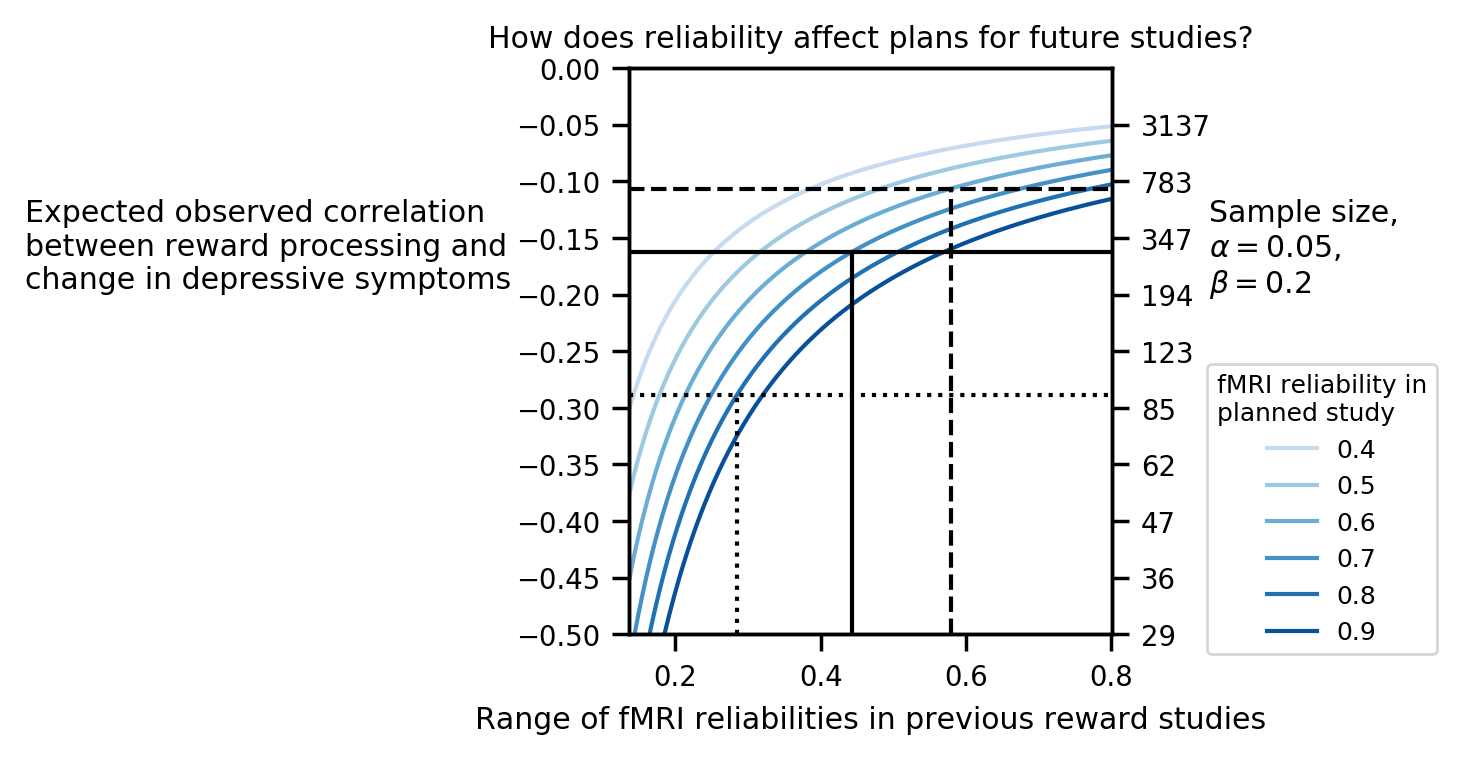

In [33]:
future_xxms = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette('Blues', len(future_xxms)+1)[1:]
xxm = np.arange(0 + 0.001,1 + 0.001,0.001)
ses = np.array([XmYm_Tbs_se, XXm_Tbs_se])
means = np.array([XmYm_Tbs, XXm_Tbs])
fym = YYm_rbs

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(7.48/3, 3), facecolor='white')
styles = ['dotted', None, 'dashed']
for fxm,cc in zip(future_xxms, colors):
    tmp = XmYm_rbs / (xxm * YYm_rbs)
    y = tmp[tmp>=-1] * (fxm * fym)
    ax.plot(xxm[tmp>=-1],y, label=fxm, color=cc)
ax.legend(title='fMRI reliability in\nplanned study',
          title_fontsize='small', fontsize='small',
          loc='upper left',
          bbox_to_anchor=(1.17,0.5))
ax.set_xlim((0.136,0.801))
ax.set_ylim((-0.5,0))
ax.set_yticks(np.arange(0, -0.55, -0.05))
ax.set_xlabel('Range of fMRI reliabilities in previous reward studies')
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()

xxm = XXm_lci
fxm = 0.8
tmp = XmYm_rbs / (xxm * YYm_rbs)
oc = tmp * fxm * fym
oss = calc_ss(oc)
oc_t, oc_tse = calc_delta_se(oc, means, ses)
oc_lci, oc_uci = get_rci(oc, oc_tse, alpha=0.05/2)

print(xxm, fxm, tmp, oc, oss, oc_lci, oc_uci )
ax.vlines(xxm, ymin, oc, zorder = 100, linestyle='dotted')
ax.hlines(oc, xmin,xmax, zorder = 100, linestyle='dotted')



xxm = XXm_rbs
fxm = 0.7
tmp = XmYm_rbs / (xxm * YYm_rbs)
oc = tmp * fxm * fym
oss = calc_ss(oc)
oc_t, oc_tse = calc_delta_se(oc, means, ses)
oc_lci, oc_uci = get_rci(oc, oc_tse, alpha=0.05/2)

print(xxm, fxm, tmp, oc, oss, oc_lci, oc_uci )

ax.vlines(xxm, ymin, oc, zorder = 100, )
ax.hlines(oc, xmin,xmax, zorder = 100, )


xxm = XXm_uci
fxm = 0.6
tmp = XmYm_rbs / (xxm * YYm_rbs)
oc = tmp * fxm * fym
oss = calc_ss(oc)
oc_t, oc_tse = calc_delta_se(oc, means, ses)
oc_lci, oc_uci = get_rci(oc, oc_tse, alpha=0.05/2)

print(xxm, fxm, tmp, oc, oss, oc_lci, oc_uci )
ax.vlines(xxm, ymin, oc, zorder = 100, linestyle='dashed')
ax.hlines(oc, xmin,xmax, zorder = 100, linestyle='dashed')


# xxm = 0.2
# fxm = 0.9
# tmp = XmYm_rbs / (xxm * YYm_rbs)
# oc = tmp * fxm * YYm_rbs
# oss = calc_ss(oc)

# ax.vlines(xxm, ymin, oc, zorder = 100, linestyle='dashdot')
# ax.hlines(oc, xmin,xmax, zorder = 100, linestyle='dashdot')

ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))
ax2 = ax.twinx()
es_ticks = ax.get_yticks()
es_ticks = es_ticks[es_ticks != 0]
ax2.set_yticks(es_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels([f'{x:0.0f}' for x in np.round(calc_ss(es_ticks))])

ax.set_ylabel('Expected observed correlation\nbetween reward processing and\nchange in depressive symptoms', rotation=0, ha='left')
ax.yaxis.set_label_coords(-1.25,0.6)
ax2.set_ylabel('Sample size,\n$\\alpha=0.05,$\n$\\beta=0.2$', rotation=0, ha='left')
ax2.yaxis.set_label_coords(1.2,0.77)
ax.set_title('How does reliability affect plans for future studies?')
fig.savefig(figure_path/'combined_true_effect.png', bbox_inches='tight')
fig.savefig(figure_path/'combined_true_effect.pdf', bbox_inches='tight')

Figure S8

0.2846162377893774 0.8 -0.4680105882666464 -0.3369676235519854 66.8286961358085 -0.6143195753422449 0.014493306323743406
0.443827681798296 0.7 -0.300124166068989 -0.18907822462346308 217.2939112858295 -0.3719398702589102 0.007910280700267303
0.5792124369613754 0.6 -0.2299733299527352 -0.12418559817447701 506.69766511509584 -0.24165864975806733 -0.0031250455810944507


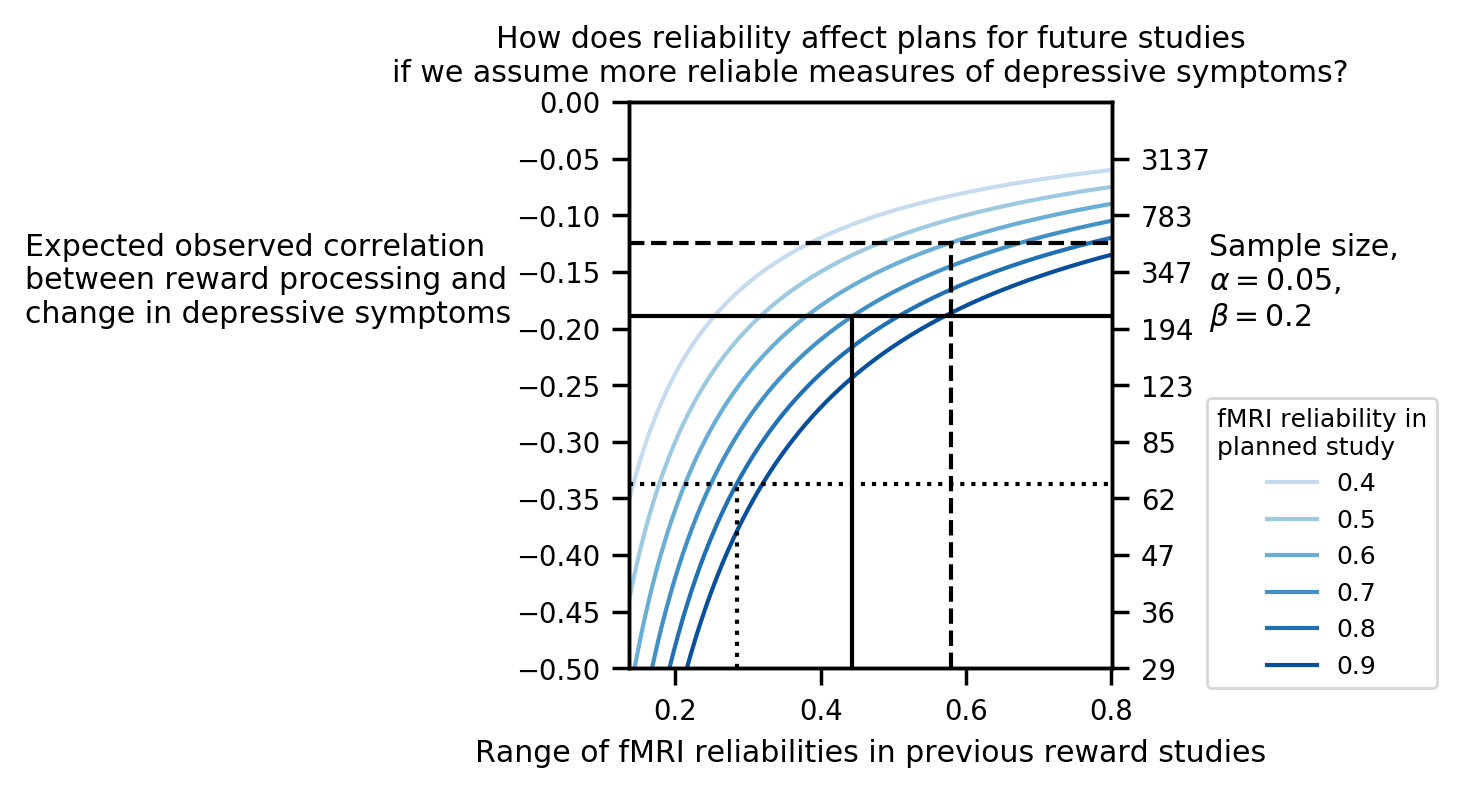

In [34]:
future_xxms = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette('Blues', len(future_xxms)+1)[1:]
xxm = np.arange(0 + 0.001,1 + 0.001,0.001)
ses = np.array([XmYm_Tbs_se, XXm_Tbs_se, YYm_Tbs_se])
means = np.array([XmYm_Tbs, XXm_Tbs, YYm_Tbs])
fym = 0.9

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(7.48/3, 3), facecolor='white')
styles = ['dotted', None, 'dashed']
for fxm,cc in zip(future_xxms, colors):
    tmp = XmYm_rbs / (xxm * YYm_rbs)
    y = tmp[tmp>=-1] * (fxm * fym)
    ax.plot(xxm[tmp>=-1],y, label=fxm, color=cc)
ax.legend(title='fMRI reliability in\nplanned study',
          title_fontsize='small', fontsize='small',
          loc='upper left',
          bbox_to_anchor=(1.17,0.5))
ax.set_xlim((0.136,0.801))
ax.set_ylim((-0.5,0))
ax.set_yticks(np.arange(0, -0.55, -0.05))
ax.set_xlabel('Range of fMRI reliabilities in previous reward studies')
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()

xxm = XXm_lci
fxm = 0.8
tmp = XmYm_rbs / (xxm * YYm_rbs)
oc = tmp * fxm * fym
oss = calc_ss(oc)
oc_t, oc_tse = calc_delta_se(oc, means, ses)
oc_lci, oc_uci = get_rci(oc, oc_tse, alpha=0.05/len(means))

print(xxm, fxm, tmp, oc, oss, oc_lci, oc_uci )
ax.vlines(xxm, ymin, oc, zorder = 100, linestyle='dotted')
ax.hlines(oc, xmin,xmax, zorder = 100, linestyle='dotted')



xxm = XXm_rbs
fxm = 0.7
tmp = XmYm_rbs / (xxm * YYm_rbs)
oc = tmp * fxm * fym
oss = calc_ss(oc)
oc_t, oc_tse = calc_delta_se(oc, means, ses)
oc_lci, oc_uci = get_rci(oc, oc_tse, alpha=0.05/len(means))

print(xxm, fxm, tmp, oc, oss, oc_lci, oc_uci )

ax.vlines(xxm, ymin, oc, zorder = 100, )
ax.hlines(oc, xmin,xmax, zorder = 100, )


xxm = XXm_uci
fxm = 0.6
tmp = XmYm_rbs / (xxm * YYm_rbs)
oc = tmp * fxm * fym
oss = calc_ss(oc)
oc_t, oc_tse = calc_delta_se(oc, means, ses)
oc_lci, oc_uci = get_rci(oc, oc_tse, alpha=0.05/2)

print(xxm, fxm, tmp, oc, oss, oc_lci, oc_uci )
ax.vlines(xxm, ymin, oc, zorder = 100, linestyle='dashed')
ax.hlines(oc, xmin,xmax, zorder = 100, linestyle='dashed')


# xxm = 0.2
# fxm = 0.9
# tmp = XmYm_rbs / (xxm * YYm_rbs)
# oc = tmp * fxm * YYm_rbs
# oss = calc_ss(oc)

# ax.vlines(xxm, ymin, oc, zorder = 100, linestyle='dashdot')
# ax.hlines(oc, xmin,xmax, zorder = 100, linestyle='dashdot')

ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))
ax2 = ax.twinx()
es_ticks = ax.get_yticks()
es_ticks = es_ticks[es_ticks != 0]
ax2.set_yticks(es_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels([f'{x:0.0f}' for x in np.round(calc_ss(es_ticks))])

ax.set_ylabel('Expected observed correlation\nbetween reward processing and\nchange in depressive symptoms', rotation=0, ha='left')
ax.yaxis.set_label_coords(-1.25,0.6)
ax2.set_ylabel('Sample size,\n$\\alpha=0.05,$\n$\\beta=0.2$', rotation=0, ha='left')
ax2.yaxis.set_label_coords(1.2,0.77)
ax.set_title('How does reliability affect plans for future studies\nif we assume more reliable measures of depressive symptoms?')
fig.savefig(figure_path/'combined_true_effect_higher_yym.png', bbox_inches='tight')
fig.savefig(figure_path/'combined_true_effect_higher_yym.pdf', bbox_inches='tight')

# Code for plots in original submission

In [24]:
sns.set_context('paper', font_scale=2)

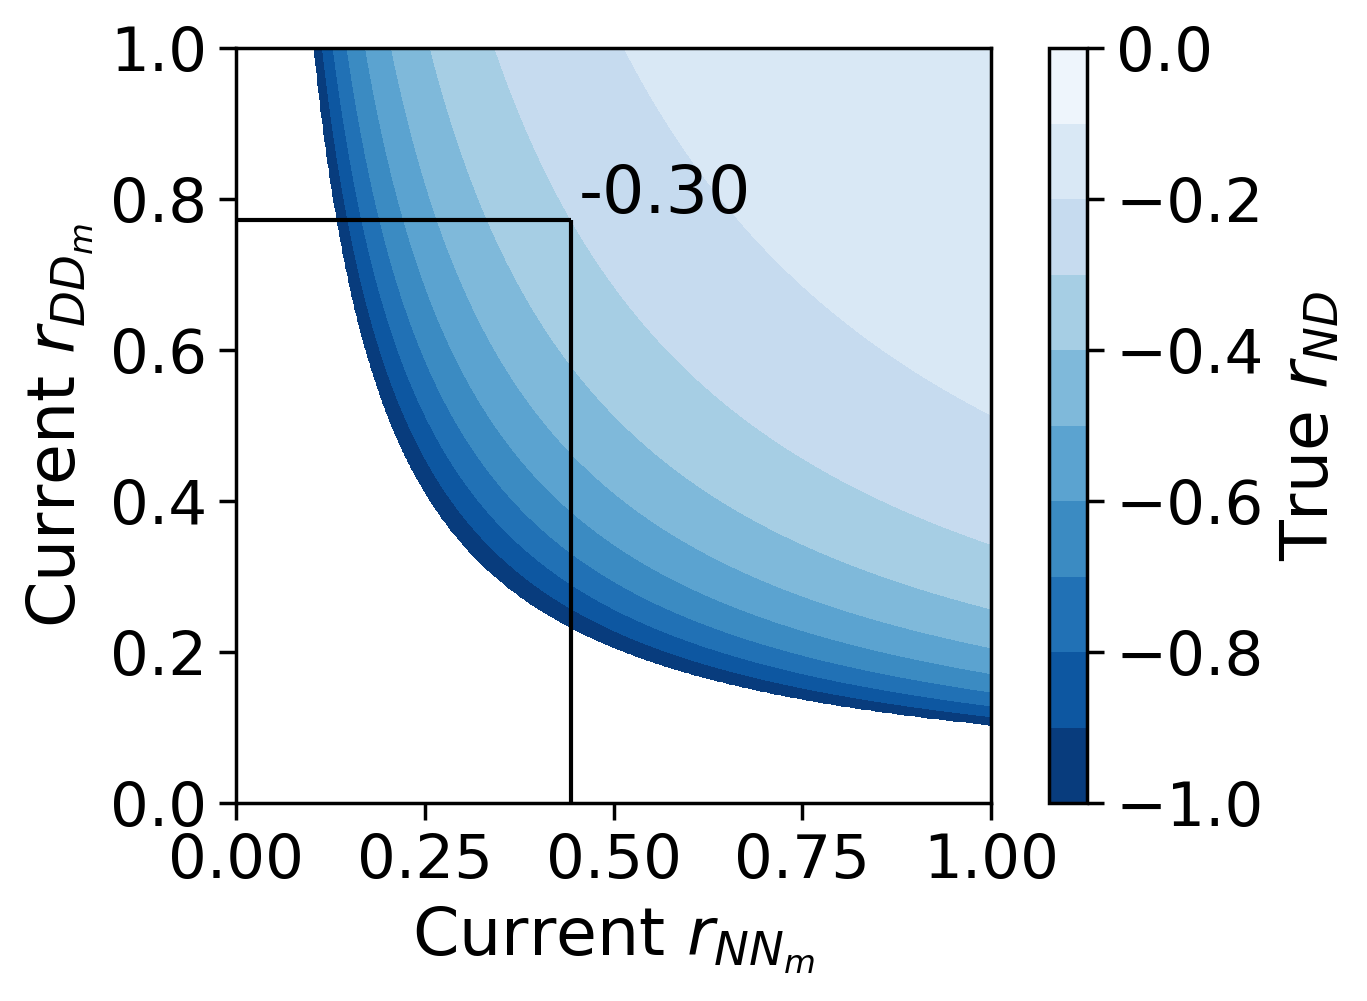

In [25]:
XXms = np.linspace(0.0001, 1, 1000)
YYms = np.linspace(0.0001, 1, 1000)
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = XmYm_rbs / (xxm * yym)
        
zz[(zz < -1)] = -10

fig,ax = plt.subplots(1, dpi=250)
contours = ax.contourf(XXms, YYms, zz, vmin=-1, vmax=0, levels=np.arange(-1,0.1, 0.1), cmap='Blues_r')
cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.2), label='True $r_{ND}$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
ax.set_xlabel('Current $r_{NN_m}$')
ax.set_ylabel('Current $r_{DD_m}$')
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.vlines(XXm_rbs,0,YYm_rbs)
ax.hlines(YYm_rbs,0,XXm_rbs)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(XXm_rbs +0.01, YYm_rbs + 0.01, f'{true_rbs:0.02f}')
fig.savefig(figure_path/'current_true.png', bbox_inches='tight')

In [26]:
ex_XXm = 0.7
ex_YYm = 0.9

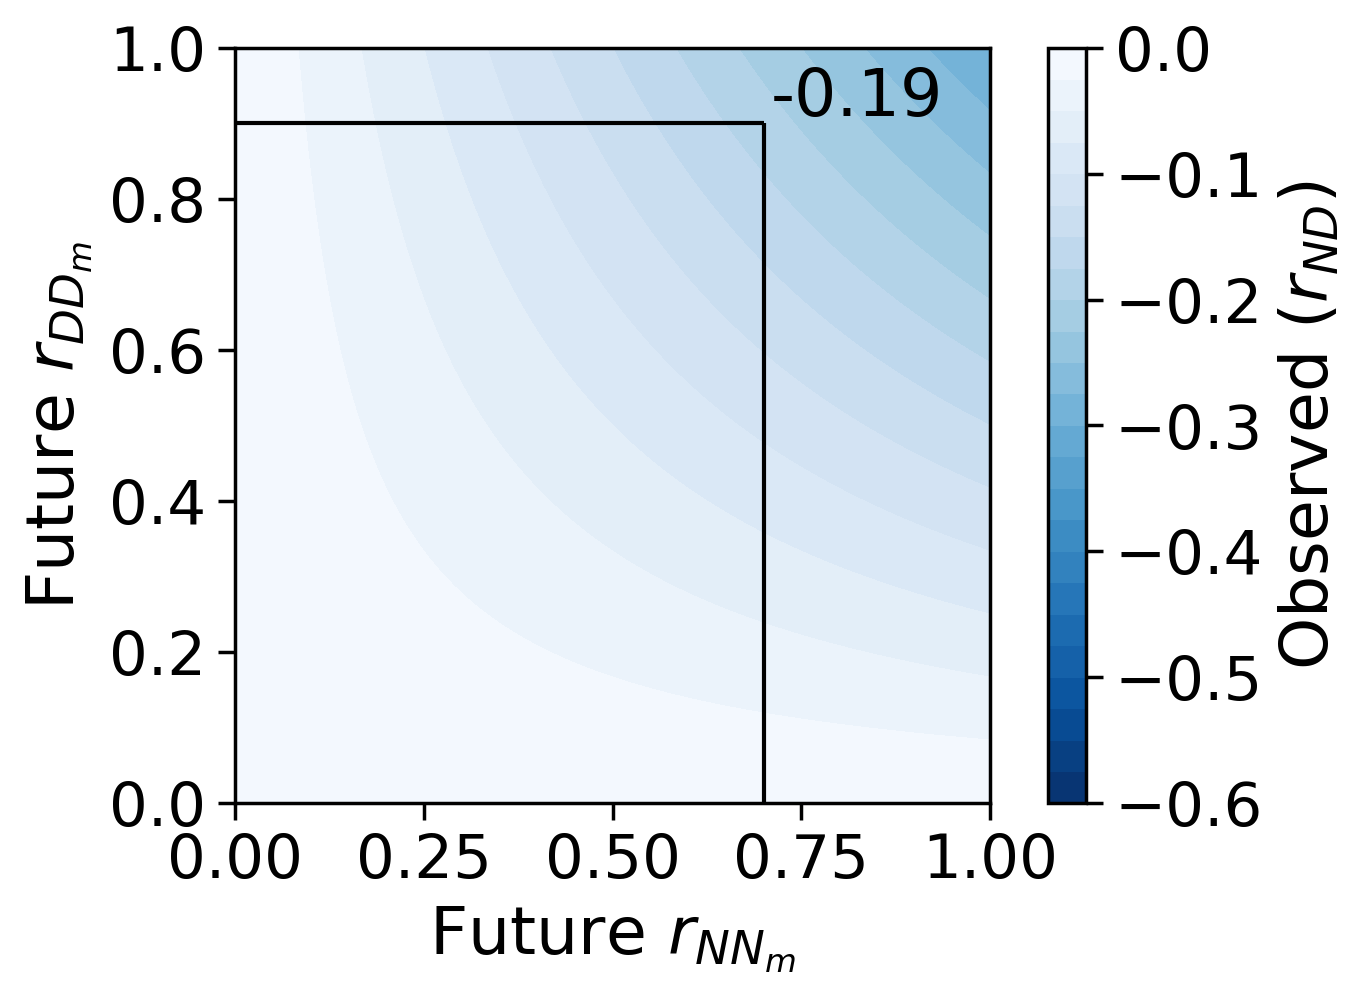

In [27]:
XXms = np.linspace(0.0001, 1, 1000)
YYms = np.linspace(0.0001, 1, 1000)
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = true_rbs * (xxm * yym)

fig,ax = plt.subplots(1, dpi=250)
contours = ax.contourf(XXms, YYms, zz, vmin=-0.6, vmax=0, levels=np.arange(-0.6,0.025, 0.025), cmap='Blues_r')
cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.1), label='Observed $(r_{ND})$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.set_xlabel('Future $r_{NN_m}$')
ax.set_ylabel('Future $r_{DD_m}$')
ax.vlines(ex_XXm, 0, ex_YYm)
ax.hlines(ex_YYm, 0, ex_XXm)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(ex_XXm +0.01, ex_YYm + 0.01, f'{true_rbs * ex_XXm * ex_YYm:0.02f}')
fig.savefig(figure_path/'future_rnd.png', bbox_inches='tight')

# Make combined figure, ended up not using this
Code below here is quite a mess.

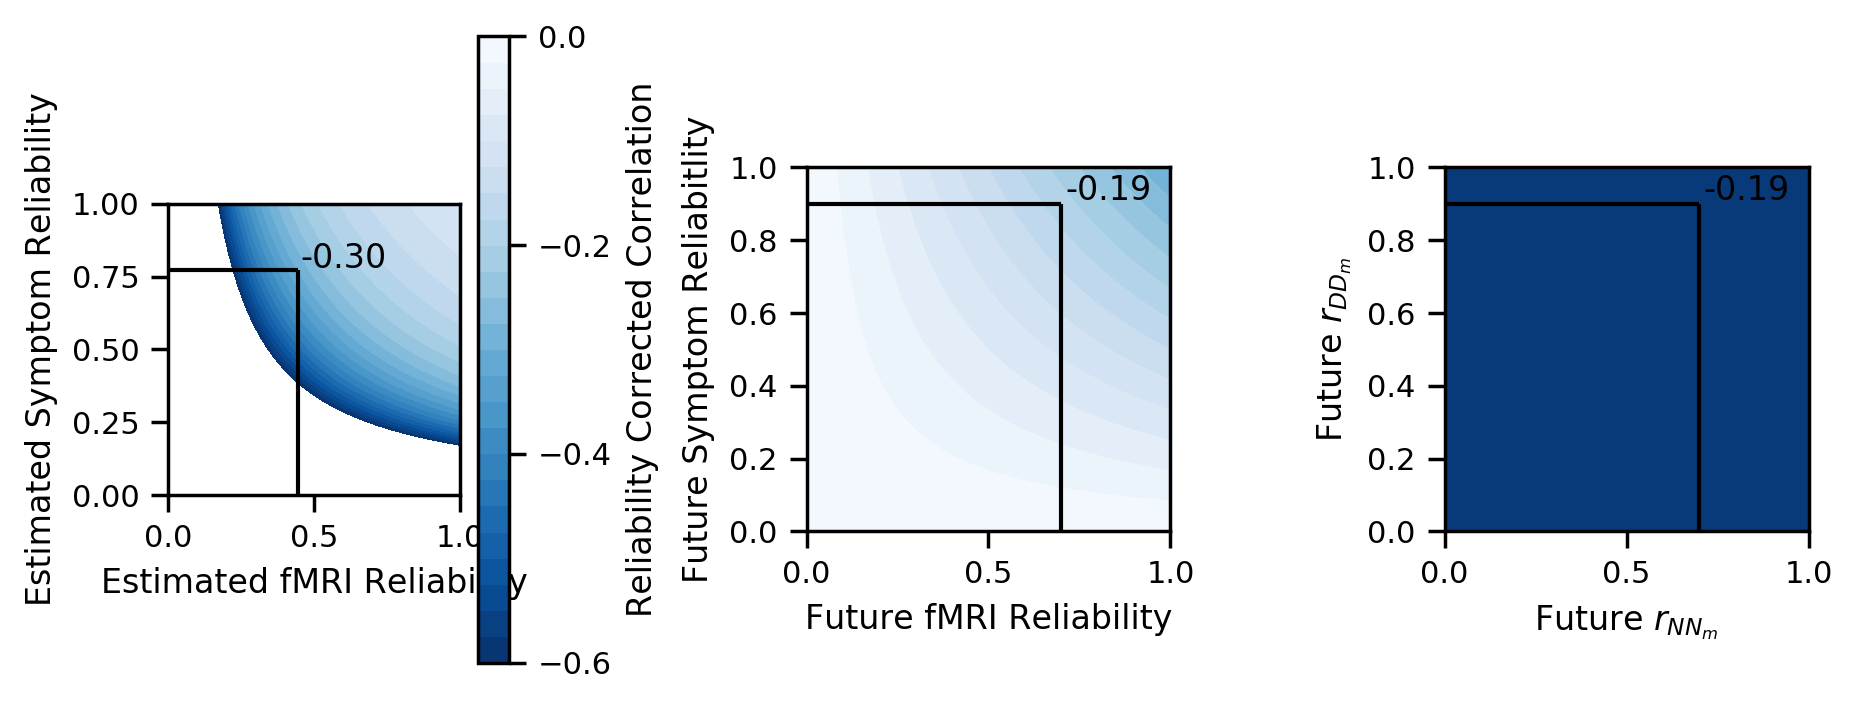

In [111]:
XXms = np.linspace(0.0001, 1, 1000)
YYms = np.linspace(0.0001, 1, 1000)
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = XmYm_rbs / (xxm * yym)
        
zz[(zz < -1)] = -10

fig,axes = plt.subplots(1, 3, dpi=250, figsize=(7.48, 3))
ax =axes[0]
contours = ax.contourf(XXms, YYms, zz, vmin=-0.6, vmax=0, levels=np.arange(-0.6,0.025, 0.025), cmap='Blues_r')
cbar = fig.colorbar(contours,ax=ax, ticks=np.arange(-1, 0.1, 0.2), label='Reliability Corrected Correlation')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
ax.set_xlabel('Estimated fMRI Reliability')
ax.set_ylabel('Estimated Symptom Reliability')
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.vlines(XXm_rbs,0,YYm_rbs)
ax.hlines(YYm_rbs,0,XXm_rbs)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(XXm_rbs +0.01, YYm_rbs + 0.01, f'{true_rbs:0.02f}')


ax = axes[1]
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = true_rbs * (xxm * yym)

contours = ax.contourf(XXms, YYms, zz, vmin=-0.6, vmax=0, levels=np.arange(-0.6,0.025, 0.025), cmap='Blues_r')
#cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.1), label='Observed $(r_{ND})$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.set_xlabel('Future fMRI Reliability')
ax.set_ylabel('Future Symptom Reliabitlity')
ax.vlines(ex_XXm, 0, ex_YYm)
ax.hlines(ex_YYm, 0, ex_XXm)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(ex_XXm +0.01, ex_YYm + 0.01, f'{true_rbs * ex_XXm * ex_YYm:0.02f}')


ax = axes[2]

contours = ax.contourf(XXms, YYms, ss_zz, vmin=0, vmax=300, levels=np.arange(0,300, 25), cmap='Blues_r')
#cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.1), label='Observed $(r_{ND})$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.set_xlabel('Future $r_{NN_m}$')
ax.set_ylabel('Future $r_{DD_m}$')
ax.vlines(ex_XXm, 0, ex_YYm)
ax.hlines(ex_YYm, 0, ex_XXm)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(ex_XXm +0.01, ex_YYm + 0.01, f'{true_rbs * ex_XXm * ex_YYm:0.02f}')


fig.tight_layout()


In [107]:
tt = power.TTestPower()
tt.solve_power(r_to_d(0.18), None, 0.05, 0.8)
ax = axes[2]
ss_zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        es = np.abs(r_to_d(true_rbs * (xxm * yym)))
        ss_zz[ii,jj] = tt.solve_power(es, None, 0.05, 0.8)

Text(0.71, 0.91, '-0.18')

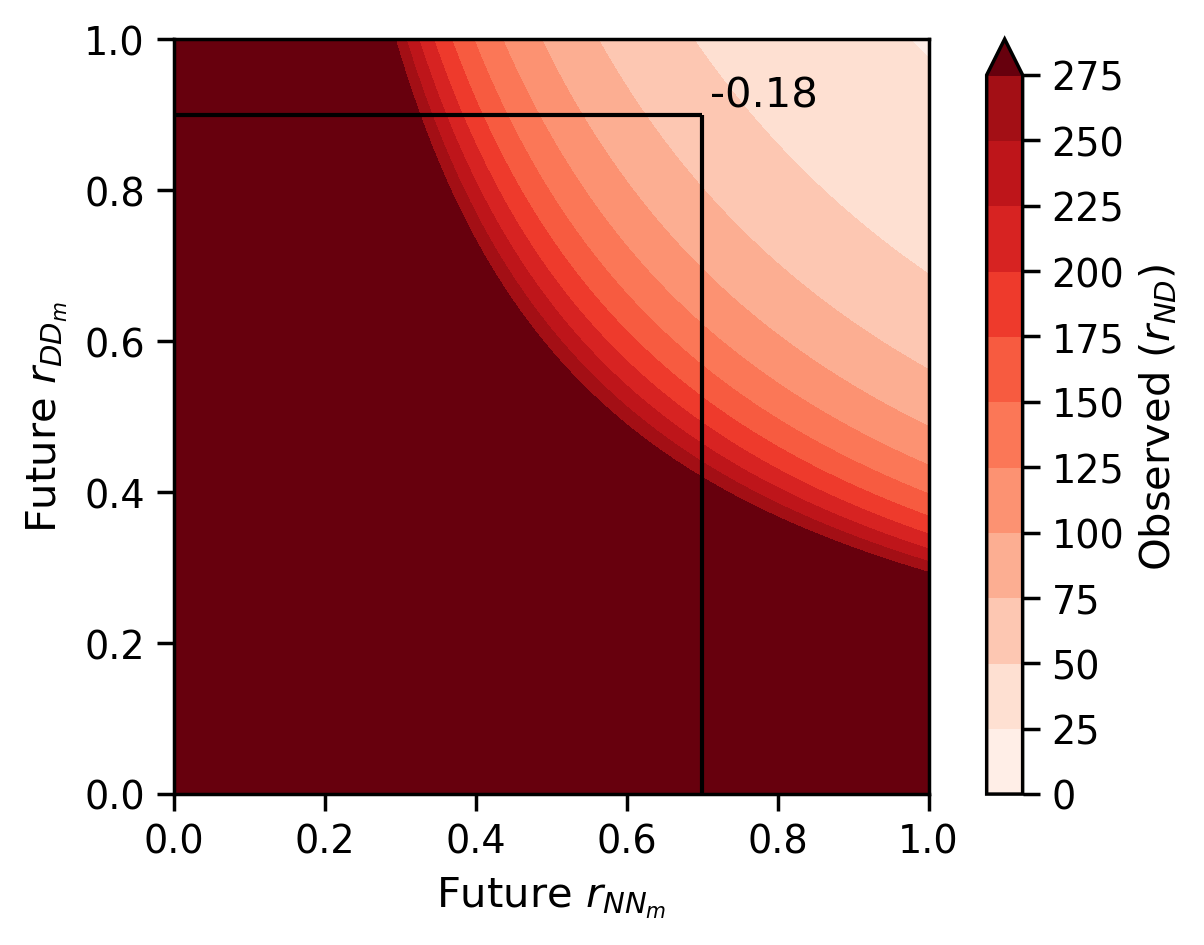

In [125]:
fig,ax = plt.subplots(1, dpi=250)

contours = ax.contourf(XXms, YYms, ss_zz, vmin=0, vmax=300, levels=np.arange(0,300, 25), cmap='Reds', extend='max')
cbar = fig.colorbar(contours, ticks=np.arange(0,300, 25), label='Observed $(r_{ND})$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.set_xlabel('Future $r_{NN_m}$')
ax.set_ylabel('Future $r_{DD_m}$')
ax.vlines(ex_XXm, 0, ex_YYm)
ax.hlines(ex_YYm, 0, ex_XXm)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(ex_XXm +0.01, ex_YYm + 0.01, f'{true_rbs * ex_XXm * ex_YYm:0.02f}')

In [ ]:
 , np.tanh(YYm_Tbs - YYm_Tbs_se *1.959964) 

In [154]:
cis = np.array([0.05])

In [155]:
z_vals = stats.norm.ppf(1 - (cis / (1+two_sided)))

In [130]:
YYm_rbs

0.7714932438963437

In [222]:
rcYYms = np.hstack([np.tanh(YYm_Tbs + YYm_Tbs_se *z_vals),[YYm_rbs], np.tanh(YYm_Tbs - YYm_Tbs_se *z_vals[::-1])])
ci_cols = {'95%':'#006d2c', 'Mean': '#2ca25f', '5%': '#66c2a4'}

In [225]:
ssYYms = [0.6, 0.7, 0.8, 0.9]
ss_cols =['#a6bddb', '#74a9cf', '#2b8cbe', '#045a8d']

In [250]:
tr_zz = np.zeros((XXms.shape[0], YYms.shape[0]))

for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(rcYYms):
        tr_zz[ii,jj] = XmYm_rbs / (xxm * yym)
rc_zz = np.zeros((XXms.shape[0], YYms.shape[0]))       
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(ssYYms):
        rc_zz[ii,jj] = true_rbs * (xxm * yym)
        #ss_zz[ii,jj] = calc_ss(rc_zz[ii,jj])

XXss = np.arange(0 - 0.01,true_rbs - 0.01, -0.001)
ss_zz = calc_ss(XXss)

[Text(0, 0, '50'),
 Text(0, 0, '100'),
 Text(0, 0, '200'),
 Text(0, 0, '500'),
 Text(0, 0, '1000'),
 Text(0, 0, '2000'),
 Text(0, 0, '5000'),
 Text(0, 0, '10000')]

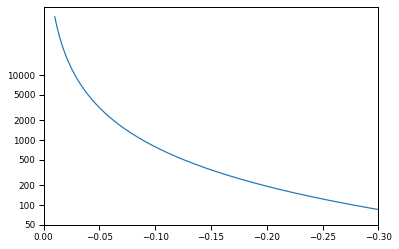

In [256]:
fig, ax = plt.subplots(1)
ax.plot(XXss, np.log10(ss_zz))
ax.set_xlim((0,-0.3))
ax.set_yticks(np.log10([50, 100, 200, 500, 1000, 2000, 5000, 10000]))
ax.set_yticklabels([50, 100, 200, 500, 1000, 2000, 5000, 10000])

array([78486.56470467, 19619.96654004,  8718.74442497,  4903.31640958,
        3137.31799744,  2178.00989698,  1599.57703383,  1224.15151222,
         966.76065566,   782.65012761,   646.42878951,   542.82091563,
         462.18924722,   398.21010192,   346.59460299,   304.35070565,
         269.33959926,   239.99954958,   215.16866063,   193.96804018,
         175.7229383 ,   159.90838208,   146.11098113,   134.00163164,
         123.31570438,   113.83846042,   105.39417538,    97.8379324 ,
          91.0493609 ,    84.92781112,    79.38860017])

In [237]:
true_rbs

-0.300124166068989

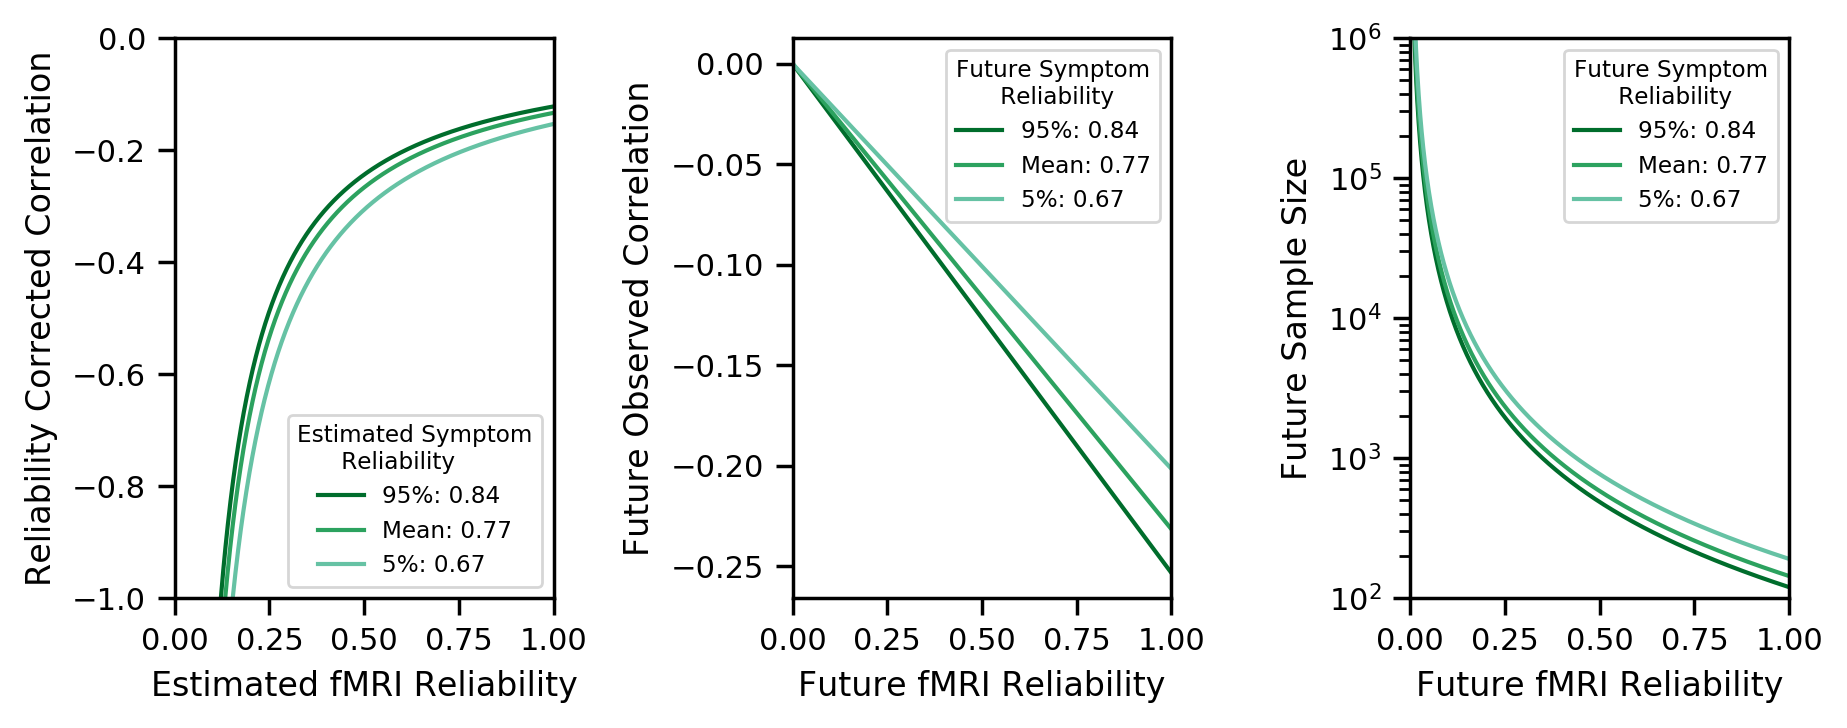

In [214]:
fig, axes = plt.subplots(1,3, dpi=250, figsize=(7.48, 3), facecolor='white')

ax = axes[0]
for jj, (ssyy,cil) in enumerate(zip(rcYYms, ci_cols.items())):
    y = tr_zz[tr_zz[:,jj] > -1, jj]
    x = XXms[tr_zz[:,jj] > -1]
    ax.plot(x,y,color=cil[1], label=f'{cil[0]}: {np.round(ssyy,2)}')
    ax.set_xlabel('Estimated fMRI Reliability')
    ax.set_ylabel('Reliability Corrected Correlation')
    #ax.set_yscale('log')
    #ymin, ymax = ax.get_ylim()
    #ax.set_ylim((100,10**6))
# ax.vlines(XXm_rbs,-1,true_rbs)
# ax.hlines(true_rbs,0,XXm_rbs)
ax.set_xlim((0,1))
ax.set_ylim((-1,0))
ax.legend(fontsize='x-small', title='Estimated Symptom\n      Reliability', title_fontsize='x-small')


ax = axes[1]
for jj, (ssyy,cil) in enumerate(zip(ssYYms, ss_cols)):
    y = rc_zz[:,jj]
    x = XXms
    ax.plot(x,y,color=cil, label=np.round(ssyy,2))
    ax.set_xlabel('Future fMRI Reliability')
    ax.set_ylabel('Future Observed Correlation')
    #ax.set_yscale('log')
    #ymin, ymax = ax.get_ylim()
    #ax.set_ylim((100,10**6))
# ax.vlines(XXm_rbs,-1,true_rbs)
# ax.hlines(true_rbs,0,XXm_rbs)
ax.set_xlim((0,1))
#ax.set_ylim((-1,0))
ax.legend(fontsize='x-small', title='Future Symptom\n      Reliability', title_fontsize='x-small')

ax = axes[2]
for jj, (ssyy,cil) in enumerate(zip(ssYYms, ss_cols)):
    y = ss_zz[:,jj]
    x = XXms
    ax.plot(x,y,color=cil, label=np.round(ssyy,2))
    ax.set_xlabel('Future fMRI Reliability')
    ax.set_ylabel('Future Sample Size')
    ax.set_yscale('log')
    #ymin, ymax = ax.get_ylim()
    ax.set_ylim((100,10**6))
# ax.vlines(XXm_rbs,-1,true_rbs)
# ax.hlines(true_rbs,0,XXm_rbs)
ax.set_xlim((0,1))
#ax.set_ylim((-1,0))
ax.legend(fontsize='x-small', title='Future Symptom\n      Reliability', title_fontsize='x-small')


fig.tight_layout()

In [263]:
xxm

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.108,
       0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117,
       0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125, 0.126,
       0.127, 0.128,

In [344]:
ylabel = ax.yaxis.get_label()
ylabel

Text(100, 0.5, '"True"\n (Reliabitlity Corrected)\n Correlation of\nRP and $\\Delta$ Dep.')

In [408]:
line_col = sns.color_palette()[2]

Text(0.5, 1.0, 'We observed a correlation of -0.10 between\n $\\Delta$Dep and RP. What would that correlation\n be in the absence of fMRI measurment error?')

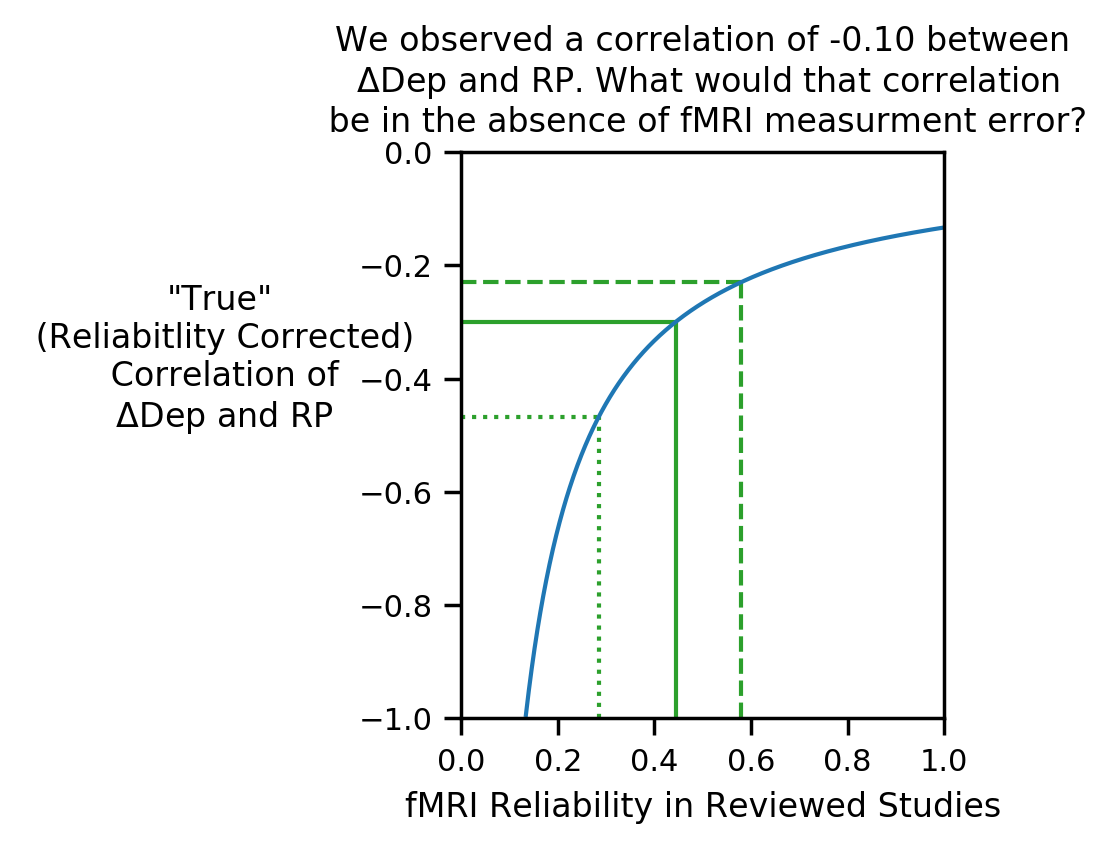

In [409]:
xxm = np.arange(0 + 0.001,1 + 0.001,0.001)
rcc = XmYm_rbs / (xxm * YYm_rbs)
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(7.48/3, 3), facecolor='white')
x = xxm[rcc >= -1]
y = rcc[rcc >= -1]
ax.plot(x,y)

# xxm = np.arange(0 + 0.001,1 + 0.001,0.001)
# rcc = XmYm_uci / (xxm * YYm_rbs)
# x = xxm[rcc >= -1]
# y = rcc[rcc >= -1]
# ax.plot(x,y)

# xxm = np.arange(0 + 0.001,1 + 0.001,0.001)
# rcc = XmYm_lci/ (xxm * YYm_rbs)
# x = xxm[rcc >= -1]
# y = rcc[rcc >= -1]
# ax.plot(x,y)


ax.vlines(XXm_rbs,-1,true_rbs, color=line_col)
ax.hlines(true_rbs,0,XXm_rbs, color=line_col)
XXm_uci_true_rbs = XmYm_rbs / (XXm_uci * YYm_rbs)
XXm_lci_true_rbs = XmYm_rbs / (XXm_lci * YYm_rbs)
ax.vlines(XXm_uci, -1, XXm_uci_true_rbs, linestyle='dashed', color=line_col)
ax.hlines(XXm_uci_true_rbs,0,XXm_uci, linestyle='dashed', color=line_col)
ax.vlines(XXm_lci, -1, XXm_lci_true_rbs, linestyle='dotted', color=line_col)
ax.hlines(XXm_lci_true_rbs,0,XXm_lci, linestyle='dotted', color=line_col)

ax.set_xlim((0,1))
ax.set_ylim((-1,0))
ax.set_xlabel('fMRI Reliability in Reviewed Studies')
ax.set_ylabel('"True"\n (Reliabitlity Corrected)\n Correlation of\n $\Delta$Dep and RP', rotation=0, ha='center')
ax.yaxis.set_label_coords(-0.5,0.5)
ax.set_title('We observed a correlation of -0.10 between\n $\Delta$Dep and RP. What would that correlation\n be in the absence of fMRI measurment error?')

In [450]:
true_rbs, XXm_lci_true_rbs, XXm_uci_true_rbs

(-0.300124166068989, -0.4680105882666464, -0.2299733299527352)

In [477]:
XmYm_rbs / (xxm * YYm_rbs)

array([-133.20341288,  -66.60170644,  -44.40113763,  -33.30085322,
        -26.64068258,  -22.20056881,  -19.02905898,  -16.65042661,
        -14.80037921,  -13.32034129,  -12.10940117,  -11.10028441,
        -10.24641638,   -9.51452949,   -8.88022753,   -8.3252133 ,
         -7.83549488,   -7.4001896 ,   -7.01070594,   -6.66017064,
         -6.34301966,   -6.05470059,   -5.79145273,   -5.5501422 ,
         -5.32813652,   -5.12320819,   -4.93345974,   -4.75726475,
         -4.59322113,   -4.44011376,   -4.29688429,   -4.16260665,
         -4.03646706,   -3.91774744,   -3.8058118 ,   -3.7000948 ,
         -3.60009224,   -3.50535297,   -3.41547213,   -3.33008532,
         -3.24886373,   -3.17150983,   -3.09775379,   -3.02735029,
         -2.96007584,   -2.89572637,   -2.83411517,   -2.7750711 ,
         -2.718437  ,   -2.66406826,   -2.61183163,   -2.56160409,
         -2.51327194,   -2.46672987,   -2.42188023,   -2.37863237,
         -2.33690198,   -2.29661057,   -2.25768496,   -2.22005

In [592]:
sns.set_context('paper', font_scale=0.9)

In [626]:
XXm_lci, XXm_uci = get_rci(XXm_rbs, XXm_Tbs_se, alpha =0.05)
XXm_rbs, XXm_lci, XXm_uci

(0.443827681798296, 0.2846162377893774, 0.5792124369613754)

In [ ]:
true_tbs = np.arctanh(true_rbs)
true_tbs_se = np.abs(true_tbs) * np.sqrt((XmYm_Tbs_se / XmYm_Tbs)**2 + (XXm_Tbs_se / XXm_Tbs)**2 + (YYm_Tbs_se / YYm_Tbs)**2)

In [636]:
ses = np.array([XmYm_Tbs_se, XXm_Tbs_se, YYm_Tbs_se])
means = np.array([XmYm_Tbs, XXm_Tbs, YYm_Tbs])

0.4349800636742232

In [643]:
true_tbs_se

0.1346942109643046

In [644]:
calc_delta_se(true_rbs, means, ses)

(-0.30965605601911755, 0.1346942109643046)

In [653]:
ses = np.array([XmYm_Tbs_se, XXm_Tbs_se])
means = np.array([XmYm_Tbs, XXm_Tbs])
oc_t, oc_tse = calc_delta_se(oc, means, ses)
get_rci(oc, oc_tse, alpha=0.05/2)

(-0.21284949587383115, -0.03349322999887825)

In [582]:
xxm = np.arange(0 + 0.001,1 + 0.001,0.001)
rat = xxm * 10
rat_oc = XmYm_rbs * rat

In [616]:
rat_oc[rat_oc<=-1]

array([-1.00093629, -1.00196395, -1.0029916 , -1.00401926, -1.00504691,
       -1.00607457, -1.00710222, -1.00812988, -1.00915754, -1.01018519,
       -1.01121285, -1.0122405 , -1.01326816, -1.01429581, -1.01532347,
       -1.01635112, -1.01737878, -1.01840643, -1.01943409, -1.02046174,
       -1.0214894 , -1.02251705, -1.02354471, -1.02457237, -1.02560002,
       -1.02662768, -1.02765533])

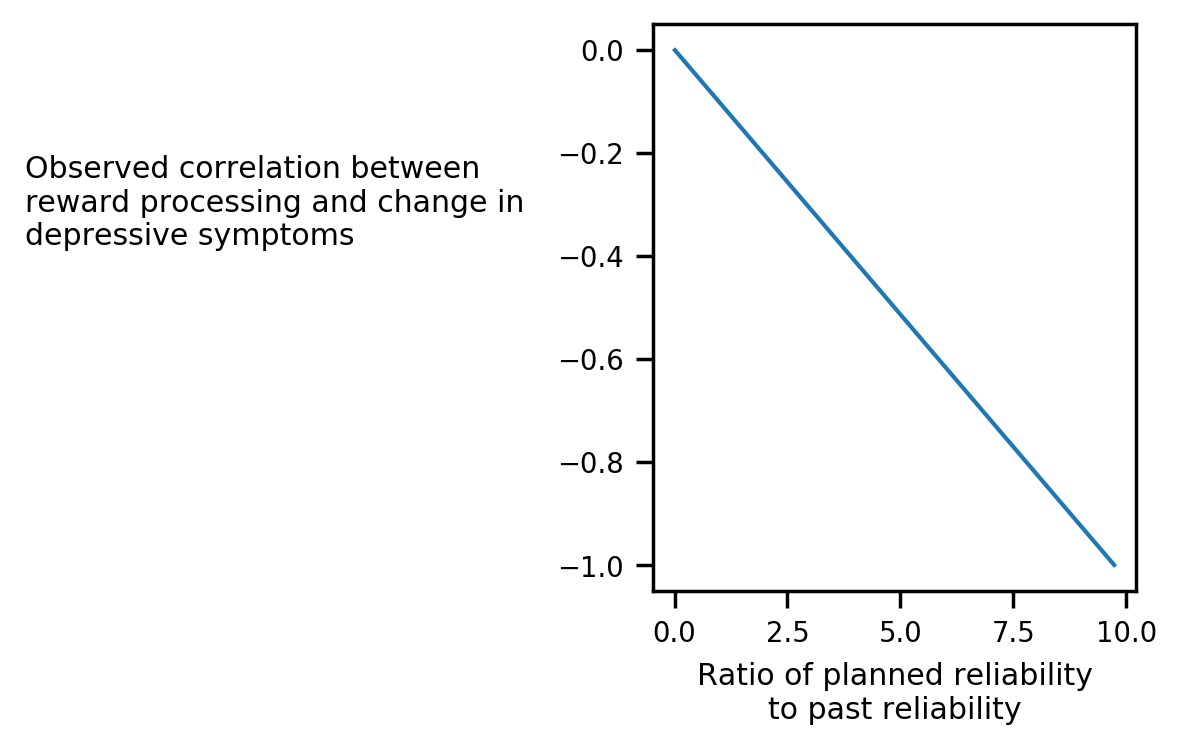

In [617]:
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(7.48/3, 3), facecolor='white')
ax.plot(rat[rat_oc>=-1], rat_oc[rat_oc>=-1])
ax.set_xlabel('Ratio of planned reliability\nto past reliability')
ax.set_ylabel('Observed correlation between\nreward processing and change in\ndepressive symptoms', rotation=0, ha='left')
ax.yaxis.set_label_coords(-1.3,0.6)

In [611]:
0.13 * 0.6, 0.8 * 0.9

(0.078, 0.7200000000000001)

In [534]:
xxm = XXm_rbs
fxm = 0.7
tmp = XmYm_rbs / (xxm * YYm_rbs)
oc = tmp * fxm * YYm_rbs
oss = calc_ss(oc)

In [538]:
tmp, oc, oss

(-0.300124166068989, -0.16208063651657448, 296.52927370130413)

Text(0.5, 1.0, 'If we planned a new study, what correlation would\n we expect to observe if fMRI had different reliability,\n and what sample size would we need?')

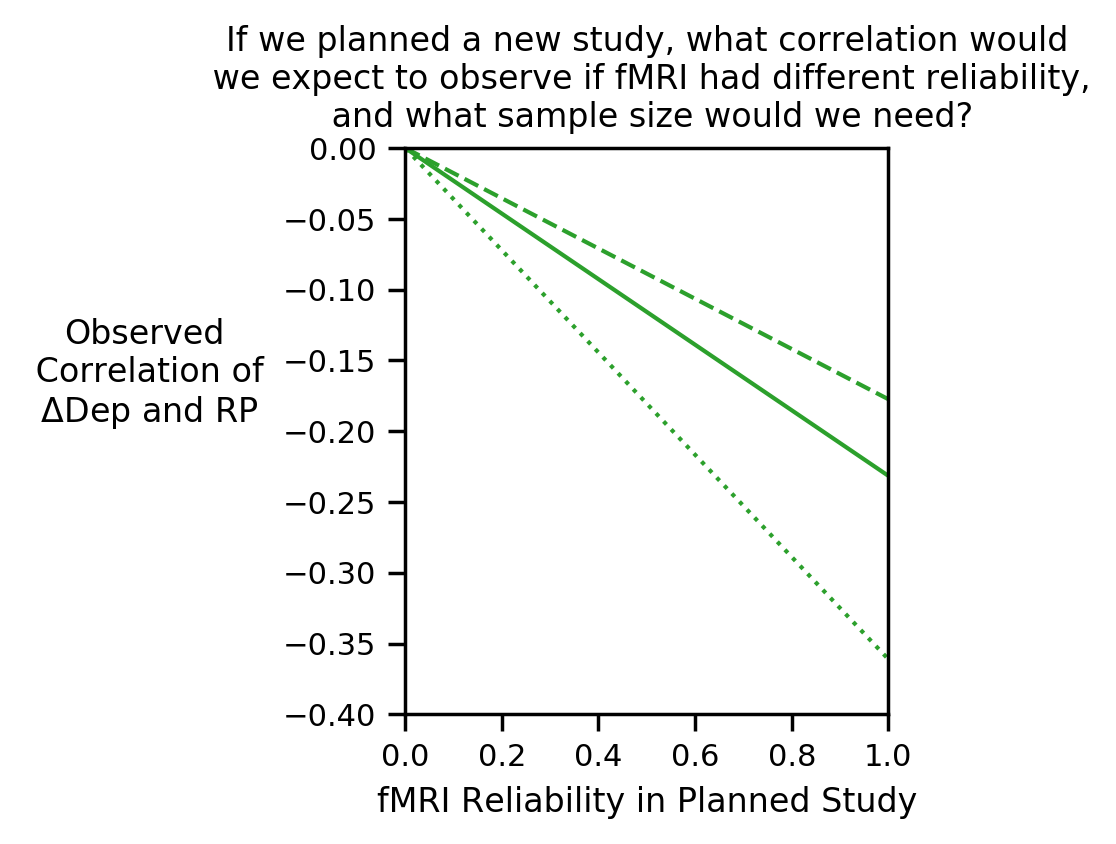

In [476]:
y_true = true_rbs * (xxm * YYm_rbs)
y_lci = XXm_lci_true_rbs * (xxm * YYm_rbs)
y_uci = XXm_uci_true_rbs * (xxm * YYm_rbs)

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(7.48/3, 3), facecolor='white')
ax.plot(xxm,y_true, color=line_col)
ax.plot(xxm,y_lci, linestyle='dotted', color=line_col)
ax.plot(xxm,y_uci, linestyle='dashed', color=line_col)
ax.set_xlim((0,1))
ax.set_ylim((-0.4,0))
ax.set_xlabel('fMRI Reliability in Planned Study')


# ax2 = ax.twinx()
# es_ticks = ax.get_yticks()
# es_ticks = es_ticks[es_ticks != 0]
# ax2.set_yticks(es_ticks)
# ax2.set_ylim(ax.get_ylim())
# ax2.set_yticklabels([f'{x:0.0f}' for x in np.round(calc_ss(es_ticks))])

ax.set_ylabel('Observed\n Correlation of\n $\Delta$Dep and RP', rotation=0, ha='center')
ax.yaxis.set_label_coords(-0.54,0.5)
# ax2.set_ylabel('Sample\nSize,\n$\\alpha=0.05$\n$\\beta=0.2$', rotation=0, ha='center')
# ax2.yaxis.set_label_coords(1.35,0.75)

ax.set_title('If we planned a new study, what correlation would\n we expect to observe if fMRI had different reliability,\n and what sample size would we need?')

Text(0.5, 1.0, 'If we planned a new study, what correlation would\n we expect to observe if fMRI had different reliability,\n and what sample size would we need?')

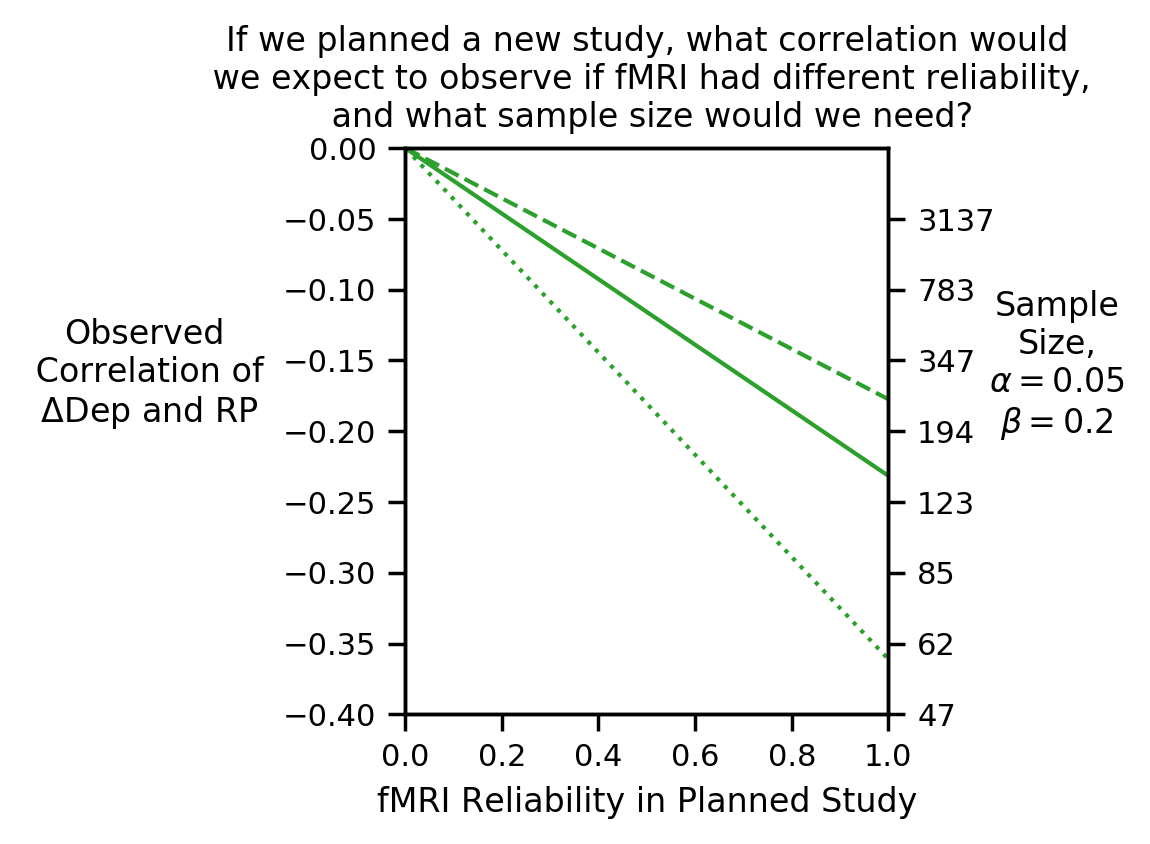

In [425]:
xxm = np.arange(0 + 0.001,1 + 0.001,0.001)
y_true = true_rbs * (xxm * YYm_rbs)
y_lci = XXm_lci_true_rbs * (xxm * YYm_rbs)
y_uci = XXm_uci_true_rbs * (xxm * YYm_rbs)

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(7.48/3, 3), facecolor='white')
ax.plot(xxm,y_true, color=line_col)
ax.plot(xxm,y_lci, linestyle='dotted', color=line_col)
ax.plot(xxm,y_uci, linestyle='dashed', color=line_col)
ax.set_xlim((0,1))
ax.set_ylim((-0.4,0))
ax.set_xlabel('fMRI Reliability in Planned Study')


ax2 = ax.twinx()
es_ticks = ax.get_yticks()
es_ticks = es_ticks[es_ticks != 0]
ax2.set_yticks(es_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels([f'{x:0.0f}' for x in np.round(calc_ss(es_ticks))])

ax.set_ylabel('Observed\n Correlation of\n $\Delta$Dep and RP', rotation=0, ha='center')
ax.yaxis.set_label_coords(-0.54,0.5)
ax2.set_ylabel('Sample\nSize,\n$\\alpha=0.05$\n$\\beta=0.2$', rotation=0, ha='center')
ax2.yaxis.set_label_coords(1.35,0.75)

ax.set_title('If we planned a new study, what correlation would\n we expect to observe if fMRI had different reliability,\n and what sample size would we need?')

In [452]:
xxm = 0.7
true_rbs *xxm * YYm_rbs, XXm_lci_true_rbs * (xxm * YYm_rbs), XXm_uci_true_rbs * (xxm * YYm_rbs)

(-0.16208063651657448, -0.25274690484376977, -0.1241960092344159)

In [453]:
calc_ss(true_rbs *xxm * YYm_rbs), calc_ss(XXm_lci_true_rbs * (xxm * YYm_rbs)), calc_ss(XXm_uci_true_rbs * (xxm * YYm_rbs))

(296.52927370130413, 120.60006273632862, 506.6123410963478)

In [431]:
from matplotlib import gridspec

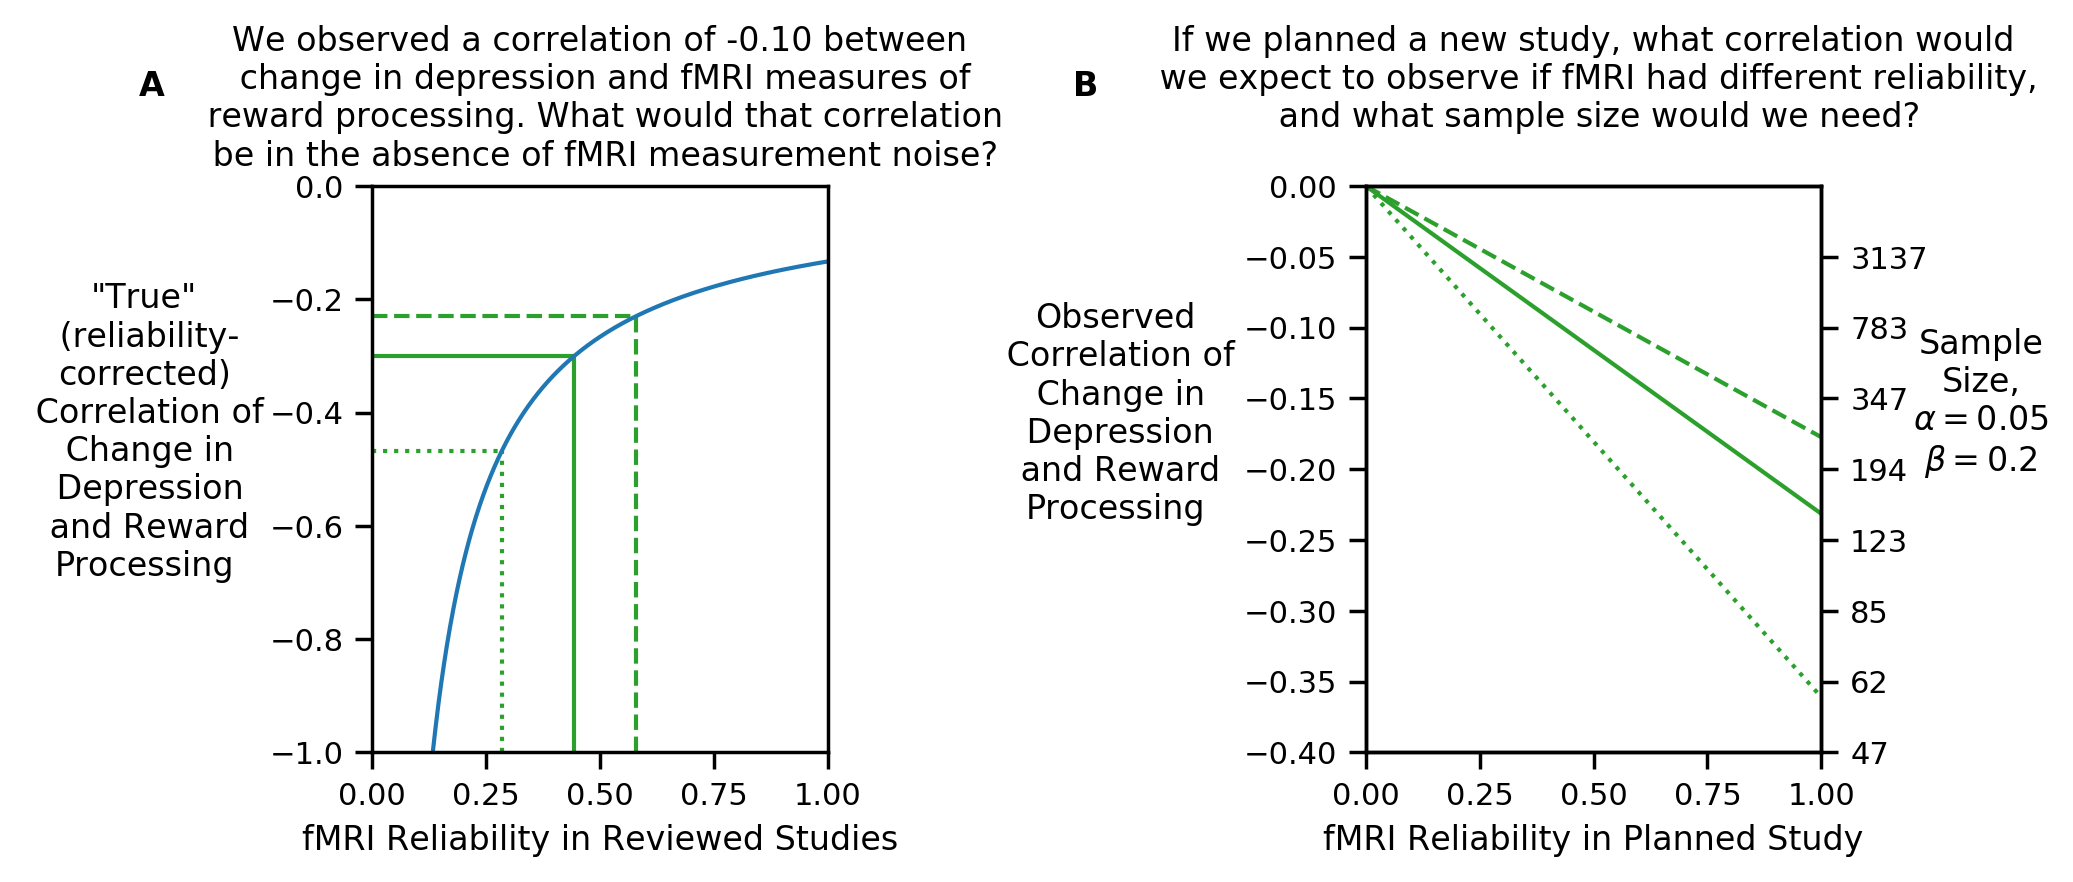

In [475]:
xxm = np.arange(0 + 0.001,1 + 0.001,0.001)
rcc = XmYm_rbs / (xxm * YYm_rbs)
# fig, axes = plt.subplots(1, 2, dpi=250, figsize=(7.48, 3), facecolor='white',)
fig = plt.figure(dpi=250, figsize=(7.48, 3), facecolor='white',)
spec = gridspec.GridSpec(1, 6, figure=fig)
axes = []
axes.append(fig.add_subplot(spec[0:2]))
axes.append(fig.add_subplot(spec[4:]))
ax = axes[0]
x = xxm[rcc >= -1]
y = rcc[rcc >= -1]
ax.plot(x,y)

# xxm = np.arange(0 + 0.001,1 + 0.001,0.001)
# rcc = XmYm_uci / (xxm * YYm_rbs)
# x = xxm[rcc >= -1]
# y = rcc[rcc >= -1]
# ax.plot(x,y)

# xxm = np.arange(0 + 0.001,1 + 0.001,0.001)
# rcc = XmYm_lci/ (xxm * YYm_rbs)
# x = xxm[rcc >= -1]
# y = rcc[rcc >= -1]
# ax.plot(x,y)


ax.vlines(XXm_rbs,-1,true_rbs, color=line_col)
ax.hlines(true_rbs,0,XXm_rbs, color=line_col)
XXm_uci_true_rbs = XmYm_rbs / (XXm_uci * YYm_rbs)
XXm_lci_true_rbs = XmYm_rbs / (XXm_lci * YYm_rbs)
ax.vlines(XXm_uci, -1, XXm_uci_true_rbs, linestyle='dashed', color=line_col)
ax.hlines(XXm_uci_true_rbs,0,XXm_uci, linestyle='dashed', color=line_col)
ax.vlines(XXm_lci, -1, XXm_lci_true_rbs, linestyle='dotted', color=line_col)
ax.hlines(XXm_lci_true_rbs,0,XXm_lci, linestyle='dotted', color=line_col)

ax.set_xlim((0,1))
ax.set_ylim((-1,0))
ax.set_xlabel('fMRI Reliability in Reviewed Studies')
ax.set_ylabel('"True"\n (reliability-\ncorrected)\n Correlation of\n Change in\n Depression\n and Reward\nProcessing', rotation=0, ha='center')
ax.yaxis.set_label_coords(-0.5,0.3)
ax.set_title('We observed a correlation of -0.10 between\n change in depression and fMRI measures of\n reward processing. What would that correlation\n be in the absence of fMRI measurement noise?')

ax = axes[1]
ax.plot(xxm,y_true, color=line_col)
ax.plot(xxm,y_lci, linestyle='dotted', color=line_col)
ax.plot(xxm,y_uci, linestyle='dashed', color=line_col)
ax.set_xlim((0,1))
ax.set_ylim((-0.4,0))
ax.set_xlabel('fMRI Reliability in Planned Study')


ax2 = ax.twinx()
es_ticks = ax.get_yticks()
es_ticks = es_ticks[es_ticks != 0]
ax2.set_yticks(es_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels([f'{x:0.0f}' for x in np.round(calc_ss(es_ticks))])

ax.set_ylabel('Observed\n Correlation of\n Change in\n Depression\n and Reward\nProcessing', rotation=0, ha='center')
ax.yaxis.set_label_coords(-0.55,0.4)
ax2.set_ylabel('Sample\nSize,\n$\\alpha=0.05$\n$\\beta=0.2$', rotation=0, ha='center')
ax2.yaxis.set_label_coords(1.35,0.75)

ax.set_title('If we planned a new study, what correlation would\n we expect to observe if fMRI had different reliability,\n and what sample size would we need?\n')
#fig.tight_layout()
fig.text(0,1,'A', weight='bold')
fig.text(0.5,1,'B', weight='bold')
fig.savefig(figure_path/'combined_true_effect.png', bbox_inches='tight')

['47', '62', '85', '123', '194', '347', '783', '3137']

In [279]:
lci_rbs

-0.559504280351829

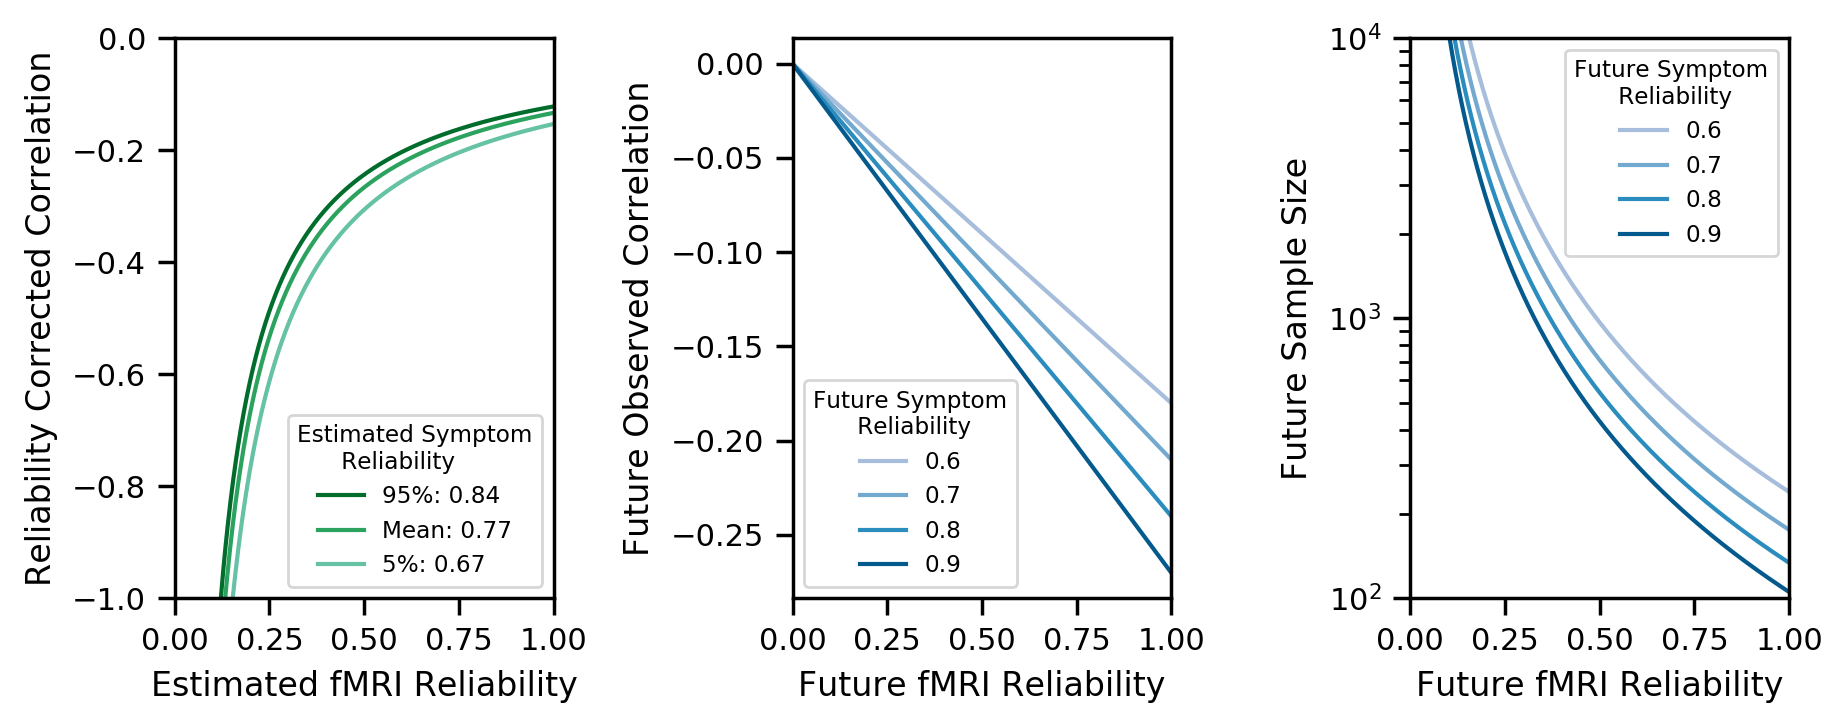

In [234]:
fig, axes = plt.subplots(1,3, dpi=250, figsize=(7.48, 3), facecolor='white')

ax = axes[0]
for jj, (ssyy,cil) in enumerate(zip(rcYYms, ci_cols.items())):
    y = tr_zz[tr_zz[:,jj] > -1, jj]
    x = XXms[tr_zz[:,jj] > -1]
    ax.plot(x,y,color=cil[1], label=f'{cil[0]}: {np.round(ssyy,2)}')
    ax.set_xlabel('Estimated fMRI Reliability')
    ax.set_ylabel('Reliability Corrected Correlation')
    #ax.set_yscale('log')
    #ymin, ymax = ax.get_ylim()
    #ax.set_ylim((100,10**6))
# ax.vlines(XXm_rbs,-1,true_rbs)
# ax.hlines(true_rbs,0,XXm_rbs)
ax.set_xlim((0,1))
ax.set_ylim((-1,0))
ax.legend(fontsize='x-small', title='Estimated Symptom\n      Reliability', title_fontsize='x-small')


ax = axes[1]
for jj, (ssyy,cil) in enumerate(zip(ssYYms, ss_cols)):
    y = rc_zz[:,jj]
    x = XXms
    ax.plot(x,y,color=cil, label=np.round(ssyy,2))
    ax.set_xlabel('Future fMRI Reliability')
    ax.set_ylabel('Future Observed Correlation')
    #ax.set_yscale('log')
    #ymin, ymax = ax.get_ylim()
    #ax.set_ylim((100,10**6))
# ax.vlines(XXm_rbs,-1,true_rbs)
# ax.hlines(true_rbs,0,XXm_rbs)
ax.set_xlim((0,1))
#ax.set_ylim((-1,0))
ax.legend(fontsize='x-small', title='Future Symptom\n      Reliability', title_fontsize='x-small')

ax = axes[2]
for jj, (ssyy,cil) in enumerate(zip(ssYYms, ss_cols)):
    y = ss_zz[:,jj]
    x = XXms
    ax.plot(x,y,color=cil, label=np.round(ssyy,2))
    ax.set_xlabel('Future fMRI Reliability')
    ax.set_ylabel('Future Sample Size')
    ax.set_yscale('log')
    #ymin, ymax = ax.get_ylim()
    ax.set_ylim((100,10**4))
# ax.vlines(XXm_rbs,-1,true_rbs)
# ax.hlines(true_rbs,0,XXm_rbs)
ax.set_xlim((0,1))
#ax.set_ylim((-1,0))
ax.legend(fontsize='x-small', title='Future Symptom\n      Reliability', title_fontsize='x-small')


fig.tight_layout()

In [232]:
ax.get_yscale()

'log'

In [229]:
true_rbs * 0.7 * 0.9

-0.18907822462346308

In [230]:
calc_ss(true_rbs * 0.7 * 0.9)

217.2939112858295

In [ ]:
rc_zz[]

In [216]:
XXm_rbs, true_rbs

(0.443827681798296, -0.300124166068989)

In [ ]:
(A) Relationship between estimated test-retest reliabitlies of symptom measures (depicted at different colored lines), est

In [178]:
true_rbs

-0.300124166068989

In [88]:
ax.get_yticks()

array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])

In [90]:
ax.get_ylim()

(46.67905194675249, 49724086449.56852)

In [76]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',
 '_init_axis',
 '_label',
 '_layoutbox',
 '_left_title',
 '_make_twin_axes',
 '_

In [64]:
stats.norm.ppf(1 - 0.05)

1.6448536269514722

In [62]:
stats.norm.ppf(1 - beta)

-0.8416212335729143

In [65]:
numr

12.365114464039532

Text(0.71, 0.91, '-0.34')

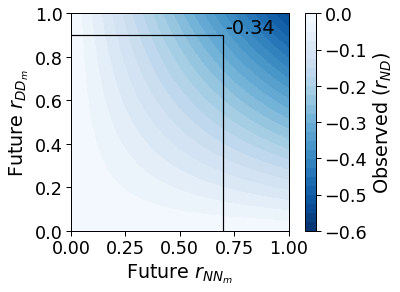

In [28]:
XXms = np.linspace(0.0001, 1, 1000)
YYms = np.linspace(0.0001, 1, 1000)
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = lci_rbs * (xxm * yym)

fig,ax = plt.subplots(1)
contours = ax.contourf(XXms, YYms, zz, vmin=-0.6, vmax=0, levels=np.arange(-0.6,0.025, 0.025), cmap='Blues_r')
cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.1), label='Observed $(r_{ND})$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.set_xlabel('Future $r_{NN_m}$')
ax.set_ylabel('Future $r_{DD_m}$')
ax.vlines(ex_XXm, 0, ex_YYm)
ax.hlines(ex_YYm, 0, ex_XXm)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(ex_XXm +0.01, ex_YYm + 0.01, f'{lci_rbs * ex_XXm * ex_YYm:0.02f}')

Text(0.71, 0.91, '0.00')

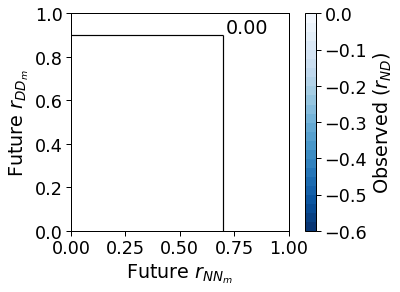

In [29]:
XXms = np.linspace(0.0001, 1, 1000)
YYms = np.linspace(0.0001, 1, 1000)
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = uci_rbs * (xxm * yym)

fig,ax = plt.subplots(1)
contours = ax.contourf(XXms, YYms, zz, vmin=-0.6, vmax=0, levels=np.arange(-0.6,0.025, 0.025), cmap='Blues_r')
cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.1), label='Observed $(r_{ND})$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.set_xlabel('Future $r_{NN_m}$')
ax.set_ylabel('Future $r_{DD_m}$')
ax.vlines(ex_XXm, 0, ex_YYm)
ax.hlines(ex_YYm, 0, ex_XXm)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(ex_XXm +0.01, ex_YYm + 0.01, f'{uci_rbs * ex_XXm * ex_YYm:0.02f}')

In [30]:
uci_rbs * ex_XXm * ex_YYm

0.004254920504253394

## Run the numbers for EEG

In [13]:
hc = 'eeg_spc_obs'
XmYm_Tbs = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_Tbs'].values[0]
XmYm_rbs = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_rbs'].values[0]
XmYm_Tbs_se = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_Tbs_se'].values[0]
XmYm_tau2 = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_tau2'].values[0]

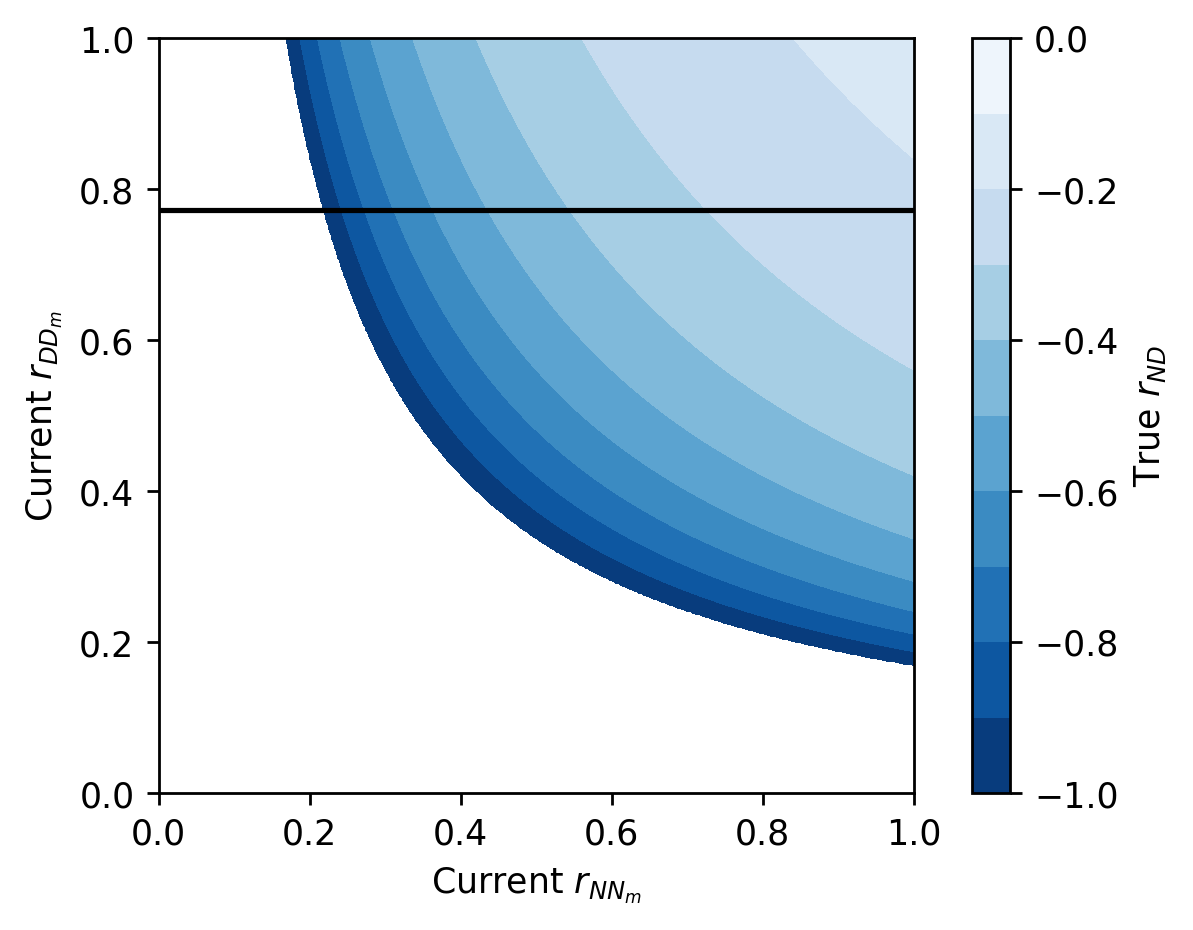

In [15]:
XXms = np.linspace(0.0001, 1, 1000)
YYms = np.linspace(0.0001, 1, 1000)
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = XmYm_rbs / (xxm * yym)
        
zz[(zz < -1)] = -10

fig,ax = plt.subplots(1, dpi=250)
contours = ax.contourf(XXms, YYms, zz, vmin=-1, vmax=0, levels=np.arange(-1,0.1, 0.1), cmap='Blues_r')
cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.2), label='True $r_{ND}$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
ax.set_xlabel('Current $r_{NN_m}$')
ax.set_ylabel('Current $r_{DD_m}$')
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.hlines(YYm_rbs,0,1)
ax.set_xlim((xmin,xmax))

fig.savefig(figure_path/'current_true_eeg.png', bbox_inches='tight')